## Import files

In [1]:

import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from doe import GP

plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
title_font=20
axis_font = 18
subt_font = 18
label_size = 16
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
pd.options.mode.chained_assignment = None  

# <change these to your paths> 
path_to_loss_file = '../../data/loss/structural_db_complete_distributions.pickle'
path_to_max_file = '../../data/loss/structural_db_complete_max_loss.pickle'

# also change this to point to the directory with the brace database
# (should be ../data/, I think)
path_to_braceShapes = '../../resource/'


## Preprocessing

In [2]:
import inverse as inv

main_obj = pd.read_pickle(path_to_loss_file)
df_loss = main_obj.loss_data
max_obj = pd.read_pickle(path_to_max_file)
df = inv.preprocess_data(main_obj, max_obj, db_string=path_to_braceShapes)


In [3]:

# view a bit of the data
pd.set_option('display.max_columns', None)
df.head()


,superstructure_system,isolator_system,num_frames,S_1,T_m,k_ratio,moat_ampli,RI,L_bldg,h_bldg,zeta_e,num_bays,num_stories,L_bay,h_story,S_s,W,W_s,w_fl,P_lc,all_w_cases,all_Plc_cases,mu_1,mu_2,R_1,R_2,T_e,k_e,Q,zeta_loop,D_m,d_bearing,d_lead,t_r,t,n_layers,N_lb,S_pad,S_2,wx,hx,h_col,hsx,Fx,Vs,T_fbe,beam,column,brace,gm_selected,scale_factor,sa_avg,sa_tm,sa_1,sa_tfb,constructed_moat,T_1,T_fb,T_ratio,gap_ratio,max_isol_disp,PID,PFV,PFA,RID,impacted,run_status,max_drift,collapse_prob,log_collapse_prob,log_drift,max_velo,max_accel,T_ratio_e,Bm,k2,k1,bldg_area,W_L,Tshift_coef,T_M_adj,sa_tm_adj,GR_OG,GR_shift_coef,sa_tm_shift,replacement_cost,total_cmp_cost,total_cmp_cost_ub,cmp_replace_cost_ratio,median_cost_ratio,cmp_cost_ratio,replacement_time,total_cmp_time,total_cmp_time_ub,cmp_replace_time_ratio,median_time_ratio,cmp_time_ratio,replacement_freq,B_50%,C_50%,D_50%,E_50%,cost_theta,cost_beta,time_l_theta,time_l_beta,cost_lam,cost_k,time_l_k,time_l_lam,cost_weibull_ks_pvalue,cost_lognormal_ks_pvalue,time_l_weibull_ks_pvalue,time_l_lognormal_ks_pvalue,cost_weibull_aic,cost_lognormal_aic,time_l_weibull_aic,time_l_lognormal_aic,steel_cost,steel_cost_per_sf,system
0,CBF,LRB,2.0,0.843053,3.361456,11.651215,0.533852,1.825811,228.89828,55.96046,0.174673,8,4,28.612285,13.990115,2.2815,24887.350813,19647.908536,"[2.8612285048189143, 2.8612285048189143, 2.861...","[4584.511991801436, 4584.511991801436, 4584.51...","{'1.4D': [2.00285995337324, 2.00285995337324, ...","{'1.4D': [3209.158394261005, 3209.158394261005...",NaN,NaN,NaN,NaN,3.361456,0.009042,0.050203,0.174674,19.478012,27.062414,5.756887,6.553734,0.344933,19.0,32.0,19.251843,4.05302,"[5239.442276344498, 5239.442276344498, 5239.44...","[167.88138105745742, 335.76276211491484, 503.6...","[167.88138105745742, 167.88138105745742, 167.8...","[167.88138105745742, 167.88138105745742, 167.8...","[77.6482106282171, 205.0501068522509, 361.8723...",1050.686385,0.572887,"[W36X160, W33X141, W33X141, W33X130]","[W14X120, W14X120, W14X120, W14X120]","[HSS8X8X5/16, HSS8X8X1/4, HSS8X8X1/4, HSS6X6X1/4]",RSN15_KERN_TAF021,5.332722,0.457718,0.190517,0.943795,1.722739,10.398366,1.398459,0.729426,4.608358,0.702771,10.8249,"[0.0016452092439332008, 0.0016374656812354568,...","[37.4653, 36.7192, 35.9945, 36.6202, 39.3401]","[0.47065217391304354, 0.26440734989648035, 0.1...","[3.728823268291737e-05, 3.7496713217087075e-05...",1,0,0.001645,4.196419e-07,-14.683864,-6.409888,39.3401,0.470652,5.867572,1.424020,0.006465,0.075321,261972.113817,11526.773008,1.0,3.361456,0.190517,0.702771,1.0,1.0,157183268.290335,6.634832e+07,8.399005e+07,0.422108,0.004211,0.009975,95619.821543,18979.885770,27132.266452,0.198493,0.003886,0.019578,0.000,2.144579e+05,1.403143e+05,2.578819e+05,0.000000,6.836625e+05,2.798914e-01,372.619184,6.324548e-01,9.004882e+05,1.594268,1.150998,557.317584,3.783591e-13,1.749285e-01,3.856888e-08,1.690837e-01,28819.964682,28437.965187,14490.588733,14231.016791,7.079132e+05,2.702246,CBF-LRB
1,CBF,LRB,2.0,1.008515,2.931504,8.332905,0.791085,0.971544,135.583077,67.976554,0.201248,5,5,27.116615,13.595311,2.2815,10570.093145,8731.816076,"[2.7116615339767955, 2.7116615339767955, 2.711...","[1470.6216549698775, 1470.6216549698775, 1470....","{'1.4D': [1.8981630737837567, 1.89816307378375...","{'1.4D': [1029.4351584789142, 1029.43515847891...",NaN,NaN,NaN,NaN,2.931504,0.011889,0.077853,0.201251,19.25918,34.812498,5.90977,13.374756,0.431444,31.0,20.0,19.882371,2.565467,"[1838.2770687123466, 1838.2770687123466, 1838....","[163.1437290993618, 326.2874581987236, 489.431...","[163.1437290993618, 163.1437290993618, 163.143...","[163.1437290993618, 163.1437290993618, 163.143...","[27.695692643559386, 101.0693110471186, 215.52...",1132.756991,0.662869,"[W40X199, W40X199, W40X167, W40X167, W33X130]","[W14X257, W14X257, W14X257, W14X257, W10X26]","[HSS10X10X3/8, HSS10X10X3/8, HSS10X10X5/16, HS...",RSN8597_SIERRA.MEX_CISWSHNN,18.877261,0.613309,0.411581,1.093088,2.03349,15.235654,1.472164,0.643693,4.554199,0.661241,16.10

Divide data into subsets

In [4]:
#%% subsets 
df_tfp = df[df['isolator_system'] == 'TFP']
df_lrb = df[df['isolator_system'] == 'LRB']

df_cbf = df[df['superstructure_system'] == 'CBF'].reset_index()
df_cbf['dummy_index'] = df_cbf['replacement_freq'] + df_cbf['index']*1e-9
df_mf = df[df['superstructure_system'] == 'MF'].reset_index()
df_mf['dummy_index'] = df_mf['replacement_freq'] + df_mf['index']*1e-9

df_mf_o = df_mf[df_mf['impacted'] == 0]
df_cbf_o = df_cbf[df_cbf['impacted'] == 0]

df_mf_tfp = df_tfp[df_tfp['superstructure_system'] == 'MF']
df_mf_lrb = df_lrb[df_lrb['superstructure_system'] == 'MF']

df_cbf_tfp = df_tfp[df_tfp['superstructure_system'] == 'CBF']
df_cbf_lrb = df_lrb[df_lrb['superstructure_system'] == 'CBF']


df_mf_tfp_i = df_mf_tfp[df_mf_tfp['impacted'] == 1]
df_mf_tfp_o = df_mf_tfp[df_mf_tfp['impacted'] == 0]
df_mf_lrb_i = df_mf_lrb[df_mf_lrb['impacted'] == 1]
df_mf_lrb_o = df_mf_lrb[df_mf_lrb['impacted'] == 0]

df_cbf_tfp_i = df_cbf_tfp[df_cbf_tfp['impacted'] == 1]
df_cbf_tfp_o = df_cbf_tfp[df_cbf_tfp['impacted'] == 0]
df_cbf_lrb_i = df_cbf_lrb[df_cbf_lrb['impacted'] == 1]
df_cbf_lrb_o = df_cbf_lrb[df_cbf_lrb['impacted'] == 0]

print(len(df_mf_tfp))
print(len(df_mf_lrb))
print(len(df_cbf_tfp))
print(len(df_cbf_lrb))

207
293
208
292


## Plots for troubleshooting

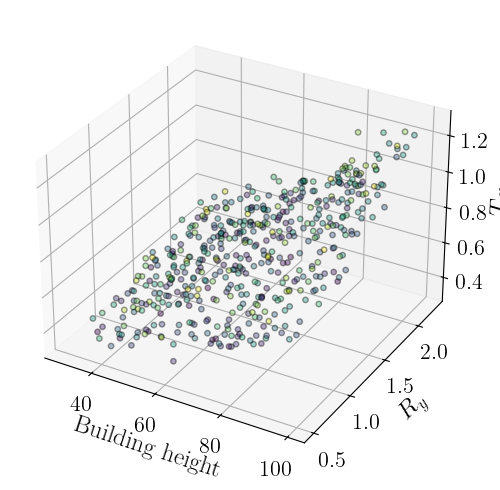

In [5]:
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1, projection='3d')
# df_plot = df_doe[df_doe['impacted'] == 1]
df_plot = df_cbf.copy()
ax.scatter(df_plot['h_bldg'], df_plot['RI'], df_plot['T_fb'], c=df_plot['T_m'], alpha=0.4, edgecolors='black', s=15)
ax.set_ylabel('$R_y$', fontsize=axis_font)
ax.set_zlabel('$T_{fb}$', fontsize=axis_font)
ax.set_xlabel('Building height', fontsize=axis_font)
# ax.set_xlim([0, 0.1])
# ax.set_ylim([0, 0.2])
plt.show()

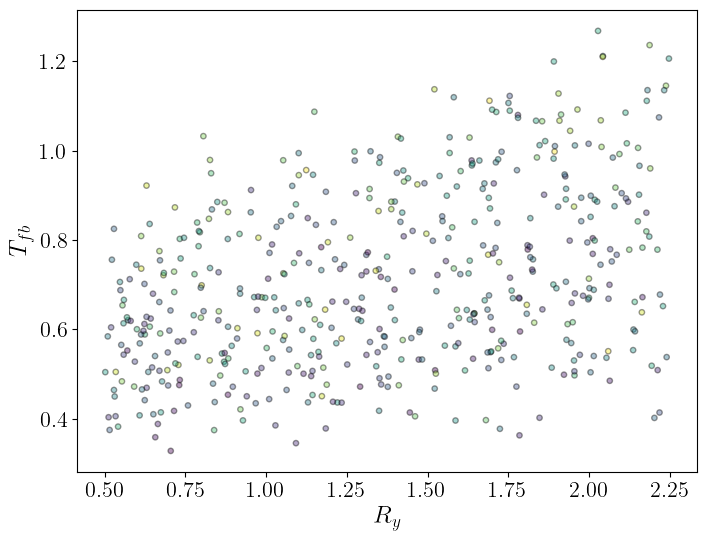

In [6]:
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1)
# df_plot = df_doe[df_doe['impacted'] == 1]
df_plot = df_cbf.copy()
ax.scatter(df_plot['RI'], df_plot['T_fb'], c=df_plot['T_m'], alpha=0.4, edgecolors='black', s=15)
ax.set_ylabel('$T_{fb}$', fontsize=axis_font)
ax.set_xlabel('$R_y$', fontsize=axis_font)
# ax.set_xlim([0, 0.1])
# ax.set_ylim([0, 0.2])
plt.show()

## MCE-level predictions (GP-$\theta$)

Impact-conditioned GP predictions

In [7]:
covariate_list = ['gap_ratio', 'RI', 'T_ratio', 'zeta_e']

mdl_all = GP(df)
mdl_all.set_covariates(covariate_list)

mdl_impact_cbf_lrb = GP(df_cbf_lrb)
mdl_impact_cbf_lrb.set_covariates(covariate_list)
mdl_impact_cbf_lrb.set_outcome('impacted')
mdl_impact_cbf_lrb.test_train_split(0.2)

mdl_impact_cbf_tfp = GP(df_cbf_tfp)
mdl_impact_cbf_tfp.set_covariates(covariate_list)
mdl_impact_cbf_tfp.set_outcome('impacted')
mdl_impact_cbf_tfp.test_train_split(0.2)

mdl_impact_mf_lrb = GP(df_mf_lrb)
mdl_impact_mf_lrb.set_covariates(covariate_list)
mdl_impact_mf_lrb.set_outcome('impacted')
mdl_impact_mf_lrb.test_train_split(0.2)

mdl_impact_mf_tfp = GP(df_mf_tfp)
mdl_impact_mf_tfp.set_covariates(covariate_list)
mdl_impact_mf_tfp.set_outcome('impacted')
mdl_impact_mf_tfp.test_train_split(0.2)

print('======= impact classification per system ========')
import time
t0 = time.time()

mdl_impact_cbf_lrb.fit_gpc(kernel_name='rbf_iso')
mdl_impact_cbf_tfp.fit_gpc(kernel_name='rbf_iso')
mdl_impact_mf_lrb.fit_gpc(kernel_name='rbf_iso')
mdl_impact_mf_tfp.fit_gpc(kernel_name='rbf_iso')

tp = time.time() - t0

print("GPC training for impact done for 4 models in %.3f s" % tp)

# density estimation model to enable constructability 
print('======= Density estimation per system ========')

t0 = time.time()

mdl_impact_mf_lrb.fit_kde(bandwidth_range=np.logspace(-3,1,20))
mdl_impact_cbf_lrb.fit_kde(bandwidth_range=np.logspace(-3,1,20))
mdl_impact_mf_tfp.fit_kde(bandwidth_range=np.logspace(-3,1,20))
mdl_impact_cbf_tfp.fit_kde(bandwidth_range=np.logspace(-3,1,20))

tp = time.time() - t0

print("KDE training done for 4 models in %.3f s" % tp)


impact_classification_mdls = {'mdl_impact_cbf_lrb': mdl_impact_cbf_lrb,
                        'mdl_impact_cbf_tfp': mdl_impact_cbf_tfp,
                        'mdl_impact_mf_lrb': mdl_impact_mf_lrb,
                        'mdl_impact_mf_tfp': mdl_impact_mf_tfp}

======= impact classification per system ========
The GP training score is 0.773
The GP testing score is 0.797
The GP training score is 0.783
The GP testing score is 0.714
The GP training score is 0.786
The GP testing score is 0.797
The GP training score is 0.824
The GP testing score is 0.762
GPC training for impact done for 4 models in 1.598 s
======= Density estimation per system ========
KDE training done for 4 models in 3.959 s


In [8]:
#%% regression models: cost
# goal: E[cost|sys=sys, impact=impact]

cost_var = 'cmp_cost_ratio'
time_var = 'cmp_time_ratio'
repl_var= 'replacement_freq'

mdl_cost_cbf_lrb_i = GP(df_cbf_lrb_i)
mdl_cost_cbf_lrb_i.set_covariates(covariate_list)
mdl_cost_cbf_lrb_i.set_outcome(cost_var)
mdl_cost_cbf_lrb_i.test_train_split(0.2)

mdl_cost_cbf_lrb_o = GP(df_cbf_lrb_o)
mdl_cost_cbf_lrb_o.set_covariates(covariate_list)
mdl_cost_cbf_lrb_o.set_outcome(cost_var)
mdl_cost_cbf_lrb_o.test_train_split(0.2)

mdl_cost_cbf_tfp_i = GP(df_cbf_tfp_i)
mdl_cost_cbf_tfp_i.set_covariates(covariate_list)
mdl_cost_cbf_tfp_i.set_outcome(cost_var)
mdl_cost_cbf_tfp_i.test_train_split(0.2)

mdl_cost_cbf_tfp_o = GP(df_cbf_tfp_o)
mdl_cost_cbf_tfp_o.set_covariates(covariate_list)
mdl_cost_cbf_tfp_o.set_outcome(cost_var)
mdl_cost_cbf_tfp_o.test_train_split(0.2)

mdl_cost_mf_lrb_i = GP(df_mf_lrb_i)
mdl_cost_mf_lrb_i.set_covariates(covariate_list)
mdl_cost_mf_lrb_i.set_outcome(cost_var)
mdl_cost_mf_lrb_i.test_train_split(0.2)

mdl_cost_mf_lrb_o = GP(df_mf_lrb_o)
mdl_cost_mf_lrb_o.set_covariates(covariate_list)
mdl_cost_mf_lrb_o.set_outcome(cost_var)
mdl_cost_mf_lrb_o.test_train_split(0.2)

mdl_cost_mf_tfp_i = GP(df_mf_tfp_i)
mdl_cost_mf_tfp_i.set_covariates(covariate_list)
mdl_cost_mf_tfp_i.set_outcome(cost_var)
mdl_cost_mf_tfp_i.test_train_split(0.2)

mdl_cost_mf_tfp_o = GP(df_mf_tfp_o)
mdl_cost_mf_tfp_o.set_covariates(covariate_list)
mdl_cost_mf_tfp_o.set_outcome(cost_var)
mdl_cost_mf_tfp_o.test_train_split(0.2)

print('======= cost regression per system per impact ========')
import time
t0 = time.time()

mdl_cost_cbf_lrb_i.fit_gpr(kernel_name='rbf_iso')
mdl_cost_cbf_lrb_o.fit_gpr(kernel_name='rbf_iso')
mdl_cost_cbf_tfp_i.fit_gpr(kernel_name='rbf_iso')
mdl_cost_cbf_tfp_o.fit_gpr(kernel_name='rbf_iso')
mdl_cost_mf_lrb_i.fit_gpr(kernel_name='rbf_iso')
mdl_cost_mf_lrb_o.fit_gpr(kernel_name='rbf_iso')
mdl_cost_mf_tfp_i.fit_gpr(kernel_name='rbf_iso')
mdl_cost_mf_tfp_o.fit_gpr(kernel_name='rbf_iso')

tp = time.time() - t0

print("GPR training for cost done for 8 models in %.3f s" % tp)

cost_regression_mdls = {'mdl_cost_cbf_lrb_i': mdl_cost_cbf_lrb_i,
                        'mdl_cost_cbf_lrb_o': mdl_cost_cbf_lrb_o,
                        'mdl_cost_cbf_tfp_i': mdl_cost_cbf_tfp_i,
                        'mdl_cost_cbf_tfp_o': mdl_cost_cbf_tfp_o,
                        'mdl_cost_mf_lrb_i': mdl_cost_mf_lrb_i,
                        'mdl_cost_mf_lrb_o': mdl_cost_mf_lrb_o,
                        'mdl_cost_mf_tfp_i': mdl_cost_mf_tfp_i,
                        'mdl_cost_mf_tfp_o': mdl_cost_mf_tfp_o}

#%% regression models: time
# goal: E[time|sys=sys, impact=impact]

mdl_time_cbf_lrb_i = GP(df_cbf_lrb_i)
mdl_time_cbf_lrb_i.set_covariates(covariate_list)
mdl_time_cbf_lrb_i.set_outcome(time_var)
mdl_time_cbf_lrb_i.test_train_split(0.2)

mdl_time_cbf_lrb_o = GP(df_cbf_lrb_o)
mdl_time_cbf_lrb_o.set_covariates(covariate_list)
mdl_time_cbf_lrb_o.set_outcome(time_var)
mdl_time_cbf_lrb_o.test_train_split(0.2)

mdl_time_cbf_tfp_i = GP(df_cbf_tfp_i)
mdl_time_cbf_tfp_i.set_covariates(covariate_list)
mdl_time_cbf_tfp_i.set_outcome(time_var)
mdl_time_cbf_tfp_i.test_train_split(0.2)

mdl_time_cbf_tfp_o = GP(df_cbf_tfp_o)
mdl_time_cbf_tfp_o.set_covariates(covariate_list)
mdl_time_cbf_tfp_o.set_outcome(time_var)
mdl_time_cbf_tfp_o.test_train_split(0.2)

mdl_time_mf_lrb_i = GP(df_mf_lrb_i)
mdl_time_mf_lrb_i.set_covariates(covariate_list)
mdl_time_mf_lrb_i.set_outcome(time_var)
mdl_time_mf_lrb_i.test_train_split(0.2)

mdl_time_mf_lrb_o = GP(df_mf_lrb_o)
mdl_time_mf_lrb_o.set_covariates(covariate_list)
mdl_time_mf_lrb_o.set_outcome(time_var)
mdl_time_mf_lrb_o.test_train_split(0.2)

mdl_time_mf_tfp_i = GP(df_mf_tfp_i)
mdl_time_mf_tfp_i.set_covariates(covariate_list)
mdl_time_mf_tfp_i.set_outcome(time_var)
mdl_time_mf_tfp_i.test_train_split(0.2)

mdl_time_mf_tfp_o = GP(df_mf_tfp_o)
mdl_time_mf_tfp_o.set_covariates(covariate_list)
mdl_time_mf_tfp_o.set_outcome(time_var)
mdl_time_mf_tfp_o.test_train_split(0.2)

print('======= downtime regression per system per impact ========')
import time
t0 = time.time()

mdl_time_cbf_lrb_i.fit_gpr(kernel_name='rbf_iso')
mdl_time_cbf_lrb_o.fit_gpr(kernel_name='rbf_iso')
mdl_time_cbf_tfp_i.fit_gpr(kernel_name='rbf_iso')
mdl_time_cbf_tfp_o.fit_gpr(kernel_name='rbf_iso')
mdl_time_mf_lrb_i.fit_gpr(kernel_name='rbf_iso')
mdl_time_mf_lrb_o.fit_gpr(kernel_name='rbf_iso')
mdl_time_mf_tfp_i.fit_gpr(kernel_name='rbf_iso')
mdl_time_mf_tfp_o.fit_gpr(kernel_name='rbf_iso')

tp = time.time() - t0

print("GPR training for time done for 8 models in %.3f s" % tp)

time_regression_mdls = {'mdl_time_cbf_lrb_i': mdl_time_cbf_lrb_i,
                        'mdl_time_cbf_lrb_o': mdl_time_cbf_lrb_o,
                        'mdl_time_cbf_tfp_i': mdl_time_cbf_tfp_i,
                        'mdl_time_cbf_tfp_o': mdl_time_cbf_tfp_o,
                        'mdl_time_mf_lrb_i': mdl_time_mf_lrb_i,
                        'mdl_time_mf_lrb_o': mdl_time_mf_lrb_o,
                        'mdl_time_mf_tfp_i': mdl_time_mf_tfp_i,
                        'mdl_time_mf_tfp_o': mdl_time_mf_tfp_o}


======= cost regression per system per impact ========
GPR training for cost done for 8 models in 2.888 s
======= downtime regression per system per impact ========
GPR training for time done for 8 models in 2.566 s


## Time-based analysis PBEE

### Load hazard scenario

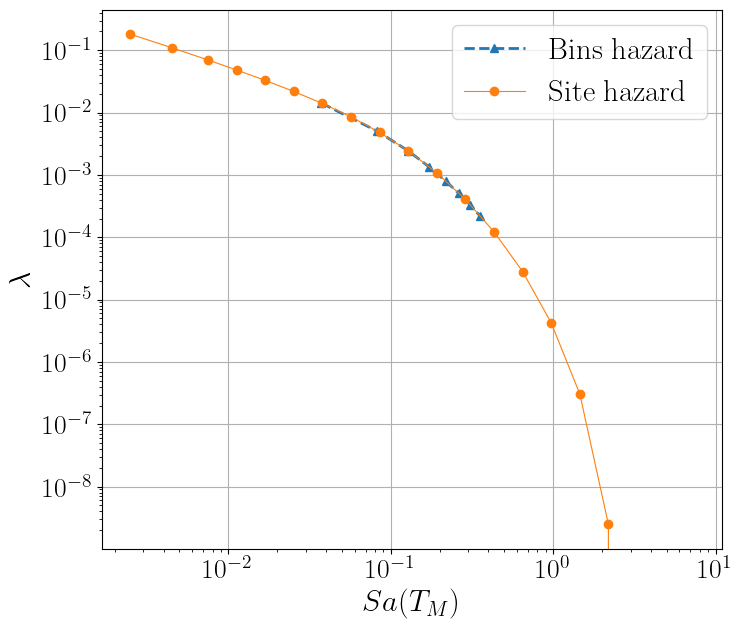

In [9]:
#%% define earthquake hazard
# reference: P-58 Implementation, Ch. 3.5

import json
import bisect
from scipy.interpolate import interp2d
with open('../../resource/hazard_curves/dwight_7th.json') as f:
    site_hazard_curves = json.load(f)['response']

np.seterr(divide='ignore')


def get_hazard_bins(T, hazard_curves, sa_max=1.016):
    T_list = [0.0, 0.1, 0.2, 0.3, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0, 5.0]
    idx_between = bisect.bisect(T_list, T)
    
    # 0 is total
    below_lambda = hazard_curves[idx_between-1]['data'][0]['yvalues']
    below_sa = hazard_curves[idx_between-1]['metadata']['xvalues']
    
    above_lambda = hazard_curves[idx_between]['data'][0]['yvalues']
    above_sa = hazard_curves[idx_between]['metadata']['xvalues']
    
    x2 = T_list[idx_between]
    x1 = T_list[idx_between-1]
    
    # assume that both series have the same length
    sa_T = [(g + h) / 2 for g, h in zip(below_sa, above_sa)]
    lambda_T = [y1+(T-x1)*(y2-y1)/(x2-x1) for y1, y2 in zip(below_lambda, above_lambda)]
    
    # sa max is max sa_avg from the dataset
    if T > 1.0:
        sa_min = 0.05/T
    else:
        sa_min = 0.05
        
    # use 8 bins
    sa_ends = np.linspace(sa_min, sa_max, 9)
    sa_bins = (sa_ends[1:] + sa_ends[:-1]) / 2
    
    # interpolate in logspace
    log_lambda = np.log(lambda_T)
    log_lambda[log_lambda == -np.inf] = -100
    lambda_bins = np.exp(np.interp(np.log(sa_bins), np.log(sa_T), log_lambda))
    
    # from here, methodology is to use sa_bins to scale ground motions and analyze
    return(sa_bins, lambda_bins, sa_T, lambda_T)

sa_bins, lambda_bins, sa_T, lambda_T = get_hazard_bins(3.36, site_hazard_curves,
                                                       sa_max=0.376)


plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
title_font=22
axis_font = 22
subt_font = 22
label_size = 20
clabel_size = 20
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
plt.close('all')

fig = plt.figure(figsize=(8,7))
ax=fig.add_subplot(1, 1, 1)

ax.loglog(sa_bins,lambda_bins, '--^', label='Bins hazard', linewidth=2.0)
ax.loglog(sa_T,lambda_T, '-o', label='Site hazard', linewidth=0.8)
ax.legend(fontsize=axis_font)
ax.set_xlabel(r'$Sa(T_M)$', fontsize=axis_font)
ax.set_ylabel(r'$\lambda$', fontsize=axis_font)
ax.grid()

Scatterhist plotting

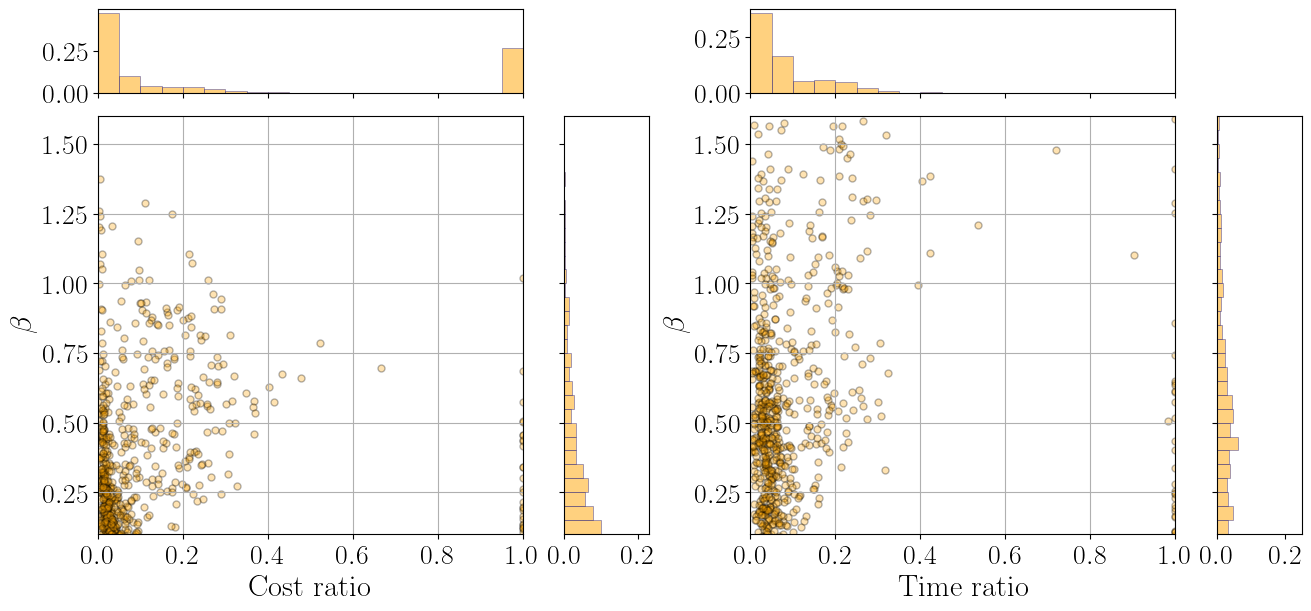

In [10]:
#%%
def scatter_hist(x, y, c, alpha, ax, ax_histx, ax_histy, label=None):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    cmap = plt.cm.Blues
    ax.scatter(x, y, alpha=alpha, edgecolors='black', s=25, facecolors=c,
               label=label)

    # now determine nice limits by hand:
    binwidth = 0.05
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    
    if y.name == 'zeta_e':
        binwidth = 0.02
        xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
        lim = (int(xymax/binwidth) + 1) * binwidth
        
        bin_y = np.arange(-lim, lim + binwidth, binwidth)
    elif y.name == 'RI':
        binwidth = 0.15
        xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
        lim = (int(xymax/binwidth) + 1) * binwidth
        
        bin_y = np.arange(-lim, lim + binwidth, binwidth)
    else:
        bin_y = bins
    ax_histx.hist(x, bins=bins, alpha = 0.5, weights=np.ones(len(x)) / len(x),
                  facecolor = c, edgecolor='navy', linewidth=0.5)
    ax_histy.hist(y, bins=bin_y, orientation='horizontal', alpha = 0.5, weights=np.ones(len(x)) / len(x),
                  facecolor = c, edgecolor='navy', linewidth=0.5)


plt.close('all')
fig = plt.figure(figsize=(13, 6), layout='constrained')

# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 4,  width_ratios=(5, 1, 5, 1), height_ratios=(1, 5),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0., hspace=0.)
# # Create the Axes.
# fig = plt.figure(figsize=(13, 10))
# ax1=fig.add_subplot(2, 2, 1)
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(df[cost_var], df['cost_beta'], 'orange', 0.3, ax, ax_histx, ax_histy)
ax.set_xlabel(r'Cost ratio', fontsize=axis_font)
ax.set_ylabel(r'$\beta$', fontsize=axis_font)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.1, 1.6])
ax.grid()

ax = fig.add_subplot(gs[1, 2])
ax_histx = fig.add_subplot(gs[0, 2], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 3], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(df[time_var], df['time_l_beta'], 'orange', 0.3, ax, ax_histx, ax_histy)

ax.set_xlabel(r'Time ratio', fontsize=axis_font)
ax.set_ylabel(r'$\beta$', fontsize=axis_font)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.1, 1.6])
ax.grid()

### Rebuild loss curve from distribution stats

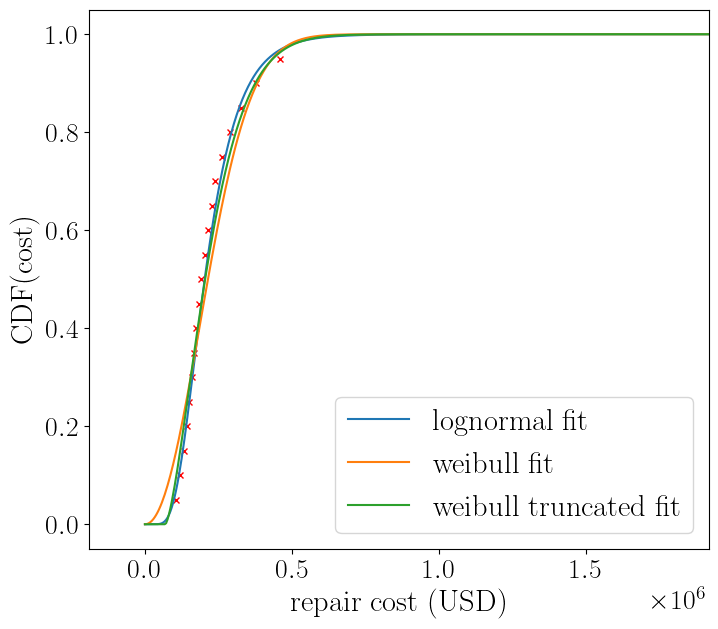

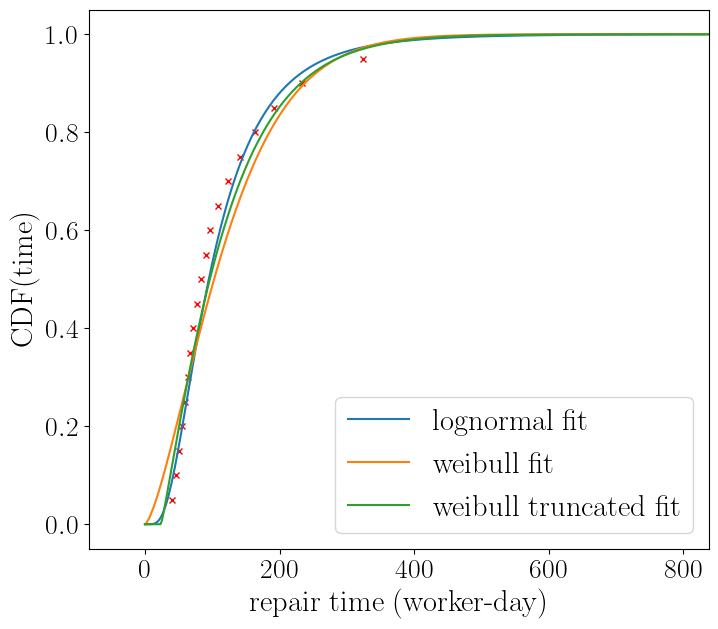

In [11]:
#%% rebuild loss curves from distros

from scipy.stats import norm

# make lambda function for generic lognormal distribution
import numpy as np
lognorm_f = lambda x,theta,beta: norm(np.log(theta), beta**0.5).cdf(np.log(x))

# make lambda function for generic weibull distribution
from scipy.stats import weibull_min
weibull_f = lambda x,k,lam,loc: weibull_min(k, loc=loc, scale=lam).cdf(x)

#%%  rebuilt curves

def plot_loss(row):
    # plot lognormal fits
    
    import matplotlib.pyplot as plt
    plt.close('all')
    fig = plt.figure(figsize=(8, 7))
    ax1=fig.add_subplot(1, 1, 1)
    
    # res = ecdf(row['repair_cost'])
    ecdf_prob = row['cost_quantiles'].index
    ecdf_values = row['cost_quantiles'].values
    median_val = row['cost_50%']
    ax1.plot([ecdf_values], [ecdf_prob], 
              marker='x', markersize=5, color="red")
    
    xx_pr = np.linspace(1e-4, 10*median_val, 400)
    p = lognorm_f(xx_pr, row['cost_theta'], row['cost_beta'])
    ax1.plot(xx_pr, p, label='lognormal fit')
    p = weibull_f(xx_pr, row['cost_k'], row['cost_lam'], 0)
    ax1.plot(xx_pr, p, label='weibull fit')  
    p = weibull_f(xx_pr, row['cost_k_trunc'], row['cost_lam_trunc'], row['cost_min'])
    ax1.plot(xx_pr, p, label='weibull truncated fit') 
    ax1.set_xlim([-median_val, 10*median_val])
    ax1.set_ylabel('CDF(cost)', fontsize=axis_font)
    ax1.set_xlabel('repair cost (USD)', fontsize=axis_font)
    ax1.legend(fontsize=axis_font)
    
    
    fig = plt.figure(figsize=(8, 7))
    ax1=fig.add_subplot(1, 1, 1)
    # res = ecdf(row['repair_cost'])
    ecdf_prob = row['time_l_quantiles'].index
    ecdf_values = row['time_l_quantiles'].values
    median_val = row['time_l_50%']
    ax1.plot([ecdf_values], [ecdf_prob], 
              marker='x', markersize=5, color="red")
    
    xx_pr = np.linspace(1e-4, 10*median_val, 400)
    p = lognorm_f(xx_pr, row['time_l_theta'], row['time_l_beta'])
    ax1.plot(xx_pr, p, label='lognormal fit')
    p = weibull_f(xx_pr, row['time_l_k'], row['time_l_lam'], 0)
    ax1.plot(xx_pr, p, label='weibull fit')  
    p = weibull_f(xx_pr, row['time_l_k_trunc'], row['time_l_lam_trunc'], row['time_l_min'])
    ax1.plot(xx_pr, p, label='weibull truncated fit') 
    ax1.set_xlim([-median_val, 10*median_val])
    ax1.set_ylabel('CDF(time)', fontsize=axis_font)
    ax1.set_xlabel('repair time (worker-day)', fontsize=axis_font)
    ax1.legend(fontsize=axis_font)

    return

current_idx = 299
current_row = df_loss.iloc[current_idx]
plot_loss(current_row)

### Theta-beta model

In [12]:
#%% regression models: beta
# goal: E[beta|theta]

### cost
beta_covariates = [cost_var]
mdl_beta_cost_mf_tfp = GP(df_mf_tfp)
mdl_beta_cost_mf_tfp.set_covariates(beta_covariates)
mdl_beta_cost_mf_tfp.set_outcome('cost_beta')
mdl_beta_cost_mf_tfp.test_train_split(0.2)

mdl_beta_cost_mf_lrb = GP(df_mf_lrb)
mdl_beta_cost_mf_lrb.set_covariates(beta_covariates)
mdl_beta_cost_mf_lrb.set_outcome('cost_beta')
mdl_beta_cost_mf_lrb.test_train_split(0.2)

mdl_beta_cost_cbf_tfp = GP(df_cbf_tfp)
mdl_beta_cost_cbf_tfp.set_covariates(beta_covariates)
mdl_beta_cost_cbf_tfp.set_outcome('cost_beta')
mdl_beta_cost_cbf_tfp.test_train_split(0.2)

mdl_beta_cost_cbf_lrb = GP(df_cbf_lrb)
mdl_beta_cost_cbf_lrb.set_covariates(beta_covariates)
mdl_beta_cost_cbf_lrb.set_outcome('cost_beta')
mdl_beta_cost_cbf_lrb.test_train_split(0.2)

### time
beta_covariates = [time_var]
mdl_beta_time_mf_tfp = GP(df_mf_tfp)
mdl_beta_time_mf_tfp.set_covariates(beta_covariates)
mdl_beta_time_mf_tfp.set_outcome('time_l_beta')
mdl_beta_time_mf_tfp.test_train_split(0.2)

mdl_beta_time_mf_lrb = GP(df_mf_lrb)
mdl_beta_time_mf_lrb.set_covariates(beta_covariates)
mdl_beta_time_mf_lrb.set_outcome('time_l_beta')
mdl_beta_time_mf_lrb.test_train_split(0.2)

mdl_beta_time_cbf_tfp = GP(df_cbf_tfp)
mdl_beta_time_cbf_tfp.set_covariates(beta_covariates)
mdl_beta_time_cbf_tfp.set_outcome('time_l_beta')
mdl_beta_time_cbf_tfp.test_train_split(0.2)

mdl_beta_time_cbf_lrb = GP(df_cbf_lrb)
mdl_beta_time_cbf_lrb.set_covariates(beta_covariates)
mdl_beta_time_cbf_lrb.set_outcome('time_l_beta')
mdl_beta_time_cbf_lrb.test_train_split(0.2)

print('======= beta regression per system  ========')
t0 = time.time()

# note, fitting kernel ridge is just kernel regression here bc only one feature
mdl_beta_cost_mf_tfp.fit_kernel_ridge(kernel_name='laplacian')
mdl_beta_cost_mf_lrb.fit_kernel_ridge(kernel_name='laplacian')
mdl_beta_cost_cbf_tfp.fit_kernel_ridge(kernel_name='laplacian')
mdl_beta_cost_cbf_lrb.fit_kernel_ridge(kernel_name='laplacian')

mdl_beta_time_mf_tfp.fit_kernel_ridge(kernel_name='laplacian')
mdl_beta_time_mf_lrb.fit_kernel_ridge(kernel_name='laplacian')
mdl_beta_time_cbf_tfp.fit_kernel_ridge(kernel_name='laplacian')
mdl_beta_time_cbf_lrb.fit_kernel_ridge(kernel_name='laplacian')

tp = time.time() - t0

print("KR training for beta done for 8 models in %.3f s" % tp)

beta_regression_mdls = {'mdl_beta_cost_mf_tfp': mdl_beta_cost_mf_tfp,
                        'mdl_beta_cost_mf_lrb': mdl_beta_cost_mf_lrb,
                        'mdl_beta_cost_cbf_tfp': mdl_beta_cost_cbf_tfp,
                        'mdl_beta_cost_cbf_lrb': mdl_beta_cost_cbf_lrb,
                        'mdl_beta_time_mf_tfp': mdl_beta_time_mf_tfp,
                        'mdl_beta_time_mf_lrb': mdl_beta_time_mf_lrb,
                        'mdl_beta_time_cbf_tfp': mdl_beta_time_cbf_tfp,
                        'mdl_beta_time_cbf_lrb': mdl_beta_time_cbf_lrb}


======= beta regression per system  ========
The best kernel ridge parameters are {'kr__alpha': 0.0001, 'kr__gamma': 0.0001}
The best kernel ridge parameters are {'kr__alpha': 0.0001, 'kr__gamma': 0.0001}
The best kernel ridge parameters are {'kr__alpha': 0.001, 'kr__gamma': 0.1}
The best kernel ridge parameters are {'kr__alpha': 0.0001, 'kr__gamma': 0.01}
The best kernel ridge parameters are {'kr__alpha': 0.0001, 'kr__gamma': 0.0001}
The best kernel ridge parameters are {'kr__alpha': 1.0, 'kr__gamma': 0.1}
The best kernel ridge parameters are {'kr__alpha': 0.1, 'kr__gamma': 1.0}
The best kernel ridge parameters are {'kr__alpha': 0.0001, 'kr__gamma': 0.0001}
KR training for beta done for 8 models in 16.560 s


Plot theta-beta regressions

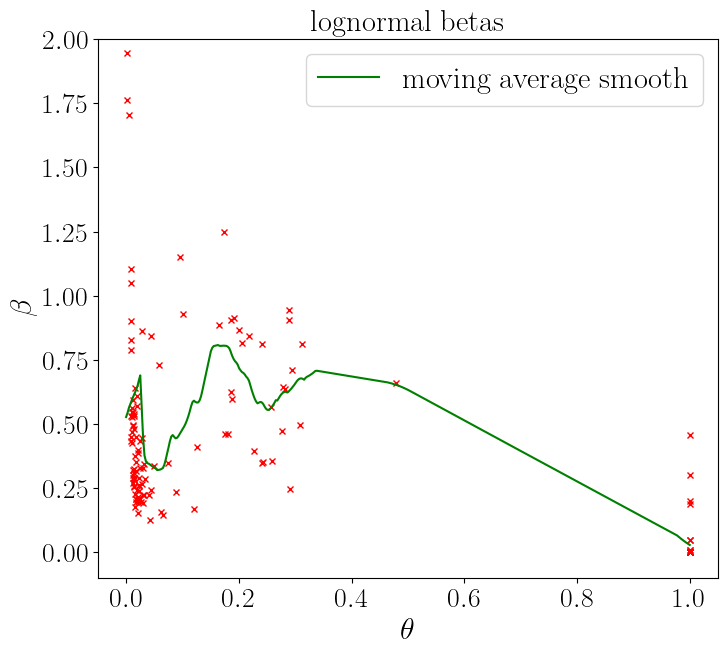

In [13]:
# low loss & extremely high loss = less dispersion
# extremely low loss: variance high bc of scaling/relative
# moderate loss: greater dispersion
import matplotlib.pyplot as plt
plt.close('all')
fig = plt.figure(figsize=(8, 7))
ax1=fig.add_subplot(1, 1, 1)
mdl_beta = mdl_beta_cost_cbf_tfp
ax1.plot([np.array(mdl_beta.X_train).ravel()], [mdl_beta.y_train], 
          marker='x', markersize=5, color="red")

nplot = 400
xx_pr = np.linspace(1e-4, 1.0, nplot).reshape(-1,1)
yy_pr = mdl_beta.kr.predict(xx_pr)

# TODO: in truth, you should not use filter/smoothing, but rather achieve smoothing
# through kernel hyperparameter bounds

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    # cumsum = np.cumsum(np.insert(y, 0, 0)) 
    # return (cumsum[box_pts:] - cumsum[:-box_pts]) / float(box_pts)
    return y_smooth


y_sm = smooth(yy_pr.ravel(), int(.05*nplot))
ax1.plot(xx_pr, y_sm, color='green', label='moving average smooth')

# yy_pr = mdl_beta.o_ridge.predict(xx_pr)
# ax1.plot(xx_pr, yy_pr, label='ordinary ridge')

# yy_pr = mdl_beta.gpr.predict(xx_pr)
# ax1.plot(xx_pr, yy_pr, label='gpr-rq')

ax1.set_ylim([-.1, 2])
ax1.set_title(r'lognormal betas', fontsize=axis_font)
ax1.set_xlabel(r'$\theta$', fontsize=axis_font)
ax1.set_ylabel(r'$\beta$', fontsize=axis_font)
ax1.legend(fontsize=axis_font)


### Calculate mean annual cumulative loss

In [14]:
from inverse import predict_DV

import numpy as np
from scipy.stats import norm
lognorm_f = lambda x,theta,beta: norm(np.log(theta), beta**0.5).cdf(np.log(x))

def calculate_lifetime_loss(row, impact_clfs, cost_regs, time_regs, beta_regs,
                            cost_var='cmp_cost_ratio', time_var='cmp_time_ratio',
                            plot_me=False):
    
    # here, we have to hack together a representation of the expected loss at different sa
    T = row['T_m']
    
    # use maximum as 1.5* mce level Sa(T_m)
    mce_Sa_Tm = row['S_1']/row['T_m']
    sa_bins, lambda_bins, sa_T, lambda_T = get_hazard_bins(T, site_hazard_curves,
                                                            sa_max=1.5*mce_Sa_Tm)
    
    
    # sa_bins, lambda_bins, sa_T, lambda_T = get_hazard_bins(T, site_hazard_curves)
    
    # how are each design variables affected by changing Sa
    # GR changes
    GR_bins = row['gap_ratio']*row['sa_tm']/sa_bins
    
    # Ry changes?
    g = 384.6
    pi = 3.14159
    Dm_bins = g*sa_bins*row['T_m']**2/(4*pi**2 * row['Bm']) 
    Ry_bins = (Dm_bins*row['k_e']*row['W']*(row['W_s']/row['W'])**(1 - 2.5*row['zeta_e'])/
               (row['Vs'] * row['num_frames']))
    
    # zeta changes?
    zeta_bins = 4*row['Q']*row['W']*Dm_bins/(2*pi*row['k_e']*row['W']*Dm_bins**2)
    
    X_bins = pd.DataFrame({'gap_ratio':GR_bins,
                         'RI':Ry_bins,
                         'T_ratio':np.repeat(row['T_ratio'], len(GR_bins)),
                         'zeta_e':np.repeat(row['zeta_e'], len(GR_bins))
                         })
    
    # # set of new design variables corresponding to the bins' hazards
    # X_bins = pd.DataFrame({'gap_ratio':GR_bins,
    #                      'RI':np.repeat(row['RI'], len(GR_bins)),
    #                      'T_ratio':np.repeat(row['T_ratio'], len(GR_bins)),
    #                      'zeta_e':np.repeat(row['zeta_e'], len(GR_bins))
    #                      })
    ############################################################################
    # approach 1
    # use GP to find the 
    ############################################################################
    # pick the correct GP models
    # get system name
    system_name = row.system.lower().replace('-','_')
    
    # identify cost models
    mdl_impact_name = 'mdl_impact_' + system_name
    mdl_cost_hit_name = 'mdl_cost_' + system_name + '_i'
    mdl_cost_miss_name = 'mdl_cost_' + system_name + '_o'
    
    mdl_impact = impact_clfs[mdl_impact_name]
    mdl_cost_hit = cost_regs[mdl_cost_hit_name]
    mdl_cost_miss = cost_regs[mdl_cost_miss_name]
    
    # identify time models
    mdl_time_hit_name = 'mdl_time_' + system_name + '_i'
    mdl_time_miss_name = 'mdl_time_' + system_name + '_o'
    
    mdl_time_hit = time_regs[mdl_time_hit_name]
    mdl_time_miss = time_regs[mdl_time_miss_name]
    
    # identify beta models
    mdl_cost_beta_name = 'mdl_beta_cost_' + system_name
    mdl_time_beta_name = 'mdl_beta_time_' + system_name
    
    mdl_cost_beta = beta_regs[mdl_cost_beta_name]
    mdl_time_beta = beta_regs[mdl_time_beta_name]
    
    # for the set of "new" design variables, use GP to calculate loss ratio
    # assumes GPC/GPR, predict the outcome for the design space
    # TODO: change this to simple GP?
    cost_ratio_bins = predict_DV(X_bins, 
                                   mdl_impact.gpc, 
                                   mdl_cost_hit.gpr, 
                                   mdl_cost_miss.gpr, 
                                   outcome=cost_var)
    
    time_ratio_bins = predict_DV(X_bins,
                                mdl_impact.gpc,
                                mdl_time_hit.gpr,
                                mdl_time_miss.gpr,
                                outcome=time_var)
    
    # predict dispersion given theta for each bin
    
    # using true kr to find beta from theta
    
    # cost_beta_bins = mdl_cost_beta.kr.predict(
    #     np.array(cost_ratio_bins[cost_var+'_pred']).reshape(-1,1))
    
    # time_beta_bins = mdl_time_beta.kr.predict(
    #     np.array(time_ratio_bins[time_var+'_pred']).reshape(-1,1))
    
    # using kr + savgol filter smoothing to find beta from theta
    nplot = 400
    xx_pr = np.linspace(1e-4, 1.2, nplot).reshape(-1,1)
    yy_pr = mdl_cost_beta.kr.predict(xx_pr)
    # y_sg = savgol_filter(yy_pr.ravel(), int(.05*nplot), 2)
    y_sm = smooth(yy_pr.ravel(), int(.05*nplot))
    # cost_beta_bins = np.interp(cost_ratio_bins[cost_var+'_pred'].values, 
    #                            xx_pr.ravel(), y_sg)
    cost_beta_bins = np.interp(cost_ratio_bins[cost_var+'_pred'].values, 
                                xx_pr.ravel(), y_sm)
    
    yy_pr = mdl_time_beta.kr.predict(xx_pr)
    # y_sg = savgol_filter(yy_pr.ravel(), int(.05*nplot), 2)
    y_sm = smooth(yy_pr.ravel(), int(.05*nplot))
    # time_beta_bins = np.interp(time_ratio_bins[time_var+'_pred'].values, 
    #                            xx_pr.ravel(), y_sg)
    time_beta_bins = np.interp(time_ratio_bins[time_var+'_pred'].values, 
                                xx_pr.ravel(), y_sm)
    
    # unnormalize loss ratio back to loss
    cost_bins = cost_ratio_bins.values*row.total_cmp_cost
    time_bins = time_ratio_bins.values*row.total_cmp_time
    
    cost_bins[cost_bins < 0.0] = 1.0
    time_bins[time_bins < 0.0] = 0.04167
    
    # set any <0 cost to a dollar
    # set any <0 time to 30 mins
    
    # make exceedance curve for each scenario
    # use total replacement just to have a bigger number
    cost_loss_values = np.linspace(1e-4, row['replacement_cost'], 1000)
    time_loss_values = np.linspace(1e-4, row['replacement_time'], 1000)
    
    
    # cost_loss_values = np.linspace(1e-4, row['total_cmp_cost'], 1000)
    # time_loss_values = np.linspace(1e-4, row['total_cmp_time'], 1000)
    
    cost_scns = np.zeros([len(cost_loss_values), len(cost_bins)])
    time_scns = np.zeros([len(time_loss_values), len(time_bins)])
    
    
    for scn_idx in range(len(cost_bins)):
        
        cost_scns[:,scn_idx] = lognorm_f(cost_loss_values, cost_bins[scn_idx], cost_beta_bins[scn_idx])
        time_scns[:,scn_idx] = lognorm_f(time_loss_values, time_bins[scn_idx], time_beta_bins[scn_idx])
        
    cost_scns[cost_loss_values > row['total_cmp_cost_ub'], :] = 1.0
    time_scns[time_loss_values > row['total_cmp_time_ub'], :] = 1.0
    
    pr_exceedance_cost = 1 - cost_scns
    pr_exceedance_time = 1 - time_scns
    
    cost_loss_rates = np.multiply(pr_exceedance_cost, lambda_bins)
    time_loss_rates = np.multiply(pr_exceedance_time, lambda_bins)
    
    if plot_me:
        import matplotlib.pyplot as plt
        colors = plt.cm.Set2(np.linspace(0,1,len(cost_bins)))
        fig = plt.figure(figsize=(8, 7))
        ax1=fig.add_subplot(1, 1, 1)
        ax1.plot(sa_bins, cost_bins.ravel(), '-o')
        ax1.set_xlabel(r'$Sa(T_M)$', fontsize=axis_font)
        ax1.set_ylabel(r'GP predicted median repair cost (\$)', fontsize=axis_font)
        ax1.grid(linewidth=0.3)
        plt.show()
        # ax1.set_xlim([0, row['replacement_cost']])
        
        fig = plt.figure(figsize=(9, 6))
        ax1=fig.add_subplot(1, 1, 1)
        
        for scn_idx in range(len(cost_bins)):
            ax1.plot(cost_loss_values, pr_exceedance_cost[:,scn_idx], 
                     color=colors[scn_idx], label='Scenario '+str(scn_idx))
            
            idx_target = np.argmin(np.abs(pr_exceedance_cost[:,scn_idx] - 0.5))
            ax1.scatter([cost_loss_values[idx_target]], [0.5], s=30.0, color=colors[scn_idx],
                        marker='s')
            
        ax1.legend(fontsize=subt_font)
        ax1.set_xlabel(r'Cost (\$)', fontsize=axis_font)
        ax1.set_ylabel(r'$Pr[X \geq \$]$', fontsize=axis_font)
        ax1.grid(linewidth=0.3)
        ax1.set_xlim([0, row['replacement_cost']])
        plt.show()
        
        
        fig = plt.figure(figsize=(9, 7))
        ax1=fig.add_subplot(1, 1, 1)
        
        for scn_idx in range(len(cost_bins)):
            if scn_idx != (len(cost_bins)-1):
                stack_color = 'lightgray'
                ax1.plot(cost_loss_values, cost_loss_rates[:,:scn_idx+1].sum(axis=1),
                        color=stack_color)
            else:
                stack_color = 'black'
                y = cost_loss_rates[:,:scn_idx+1].sum(axis=1)
                ax1.plot(cost_loss_values, y,
                        color=stack_color, label='Cumulative loss curve')
                ax1.fill_between(cost_loss_values, y, 
                                 hatch='///', color='blue', alpha=0.2)
                
        ax1.text(6e7, 0.01, r'Mean annual cumulative repair cost',
          fontsize=subt_font, color='Blue', zorder=5)
        ax1.annotate(text='', xy=(6e7, 0.01), xytext=(0.3e8, 0.0025), 
                    arrowprops=dict(arrowstyle='<-', color='Blue'))
        ax1.legend(fontsize=subt_font)
        ax1.set_xlabel(r'Cost (\$)', fontsize=axis_font)
        ax1.set_ylabel(r'$Pr[X \geq \$]$', fontsize=axis_font)
        ax1.grid(linewidth=0.3)
        ax1.set_xlim([0, row['replacement_cost']])
        plt.show()
        
        fig = plt.figure(figsize=(9, 7))
        ax1=fig.add_subplot(1, 1, 1)
        
        for scn_idx in range(len(time_bins)):
            if scn_idx != (len(cost_bins)-1):
                stack_color = 'lightgray'
                ax1.plot(time_loss_values, time_loss_rates[:,:scn_idx+1].sum(axis=1),
                        color=stack_color)
            else:
                stack_color = 'black'
                y = time_loss_rates[:,:scn_idx+1].sum(axis=1)
                ax1.plot(time_loss_values, y,
                        color=stack_color, label='Cumulative loss curve')
                ax1.fill_between(time_loss_values, y, 
                                 hatch='///', color='blue', alpha=0.2)
        ax1.legend()
        ax1.set_xlabel(r'time (man-hour)', fontsize=axis_font)
        ax1.set_ylabel(r'$Pr[X \geq t]$', fontsize=axis_font)
        ax1.grid()
        ax1.set_xlim([0, row['replacement_time']])
        plt.show()
    
    # breakpoint()
    
    # multiply scenarios' exceedance curve with corresponding return rate
    # sum across all scenarios
    agg_cost_exceedance_rate = pr_exceedance_cost @ lambda_bins
    agg_time_exceedance_rate = pr_exceedance_time @ lambda_bins
    
    # integrate to attain lifetime dollar, time
    mean_cumulative_annual_cost = np.trapz(agg_cost_exceedance_rate, cost_loss_values)
    mean_cumulative_annual_time = np.trapz(agg_time_exceedance_rate, time_loss_values)
    
    # renormalize
    
    return mean_cumulative_annual_cost, mean_cumulative_annual_time

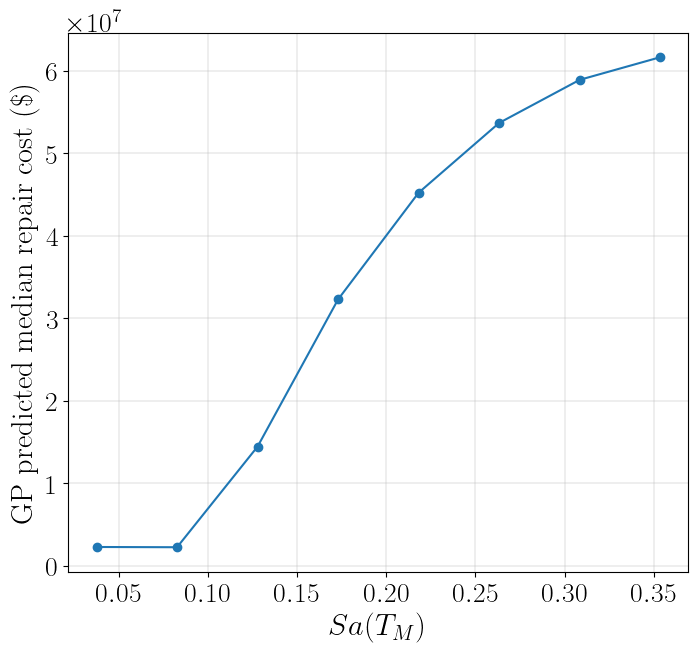

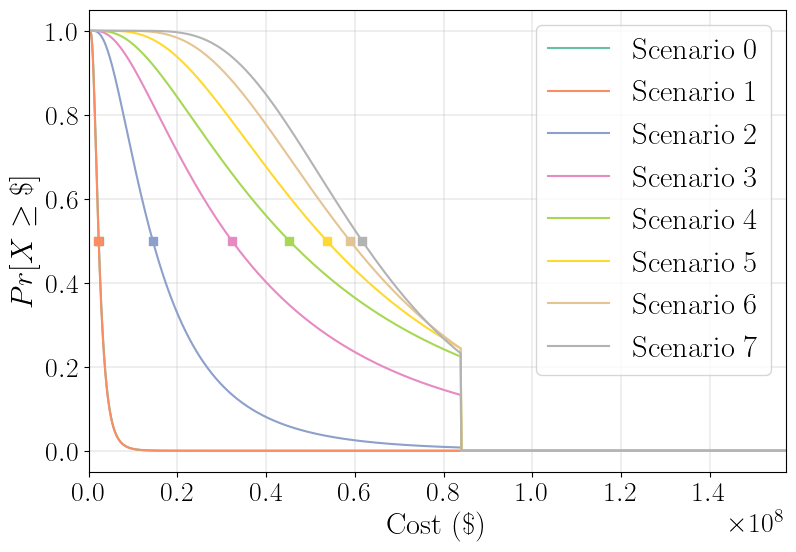

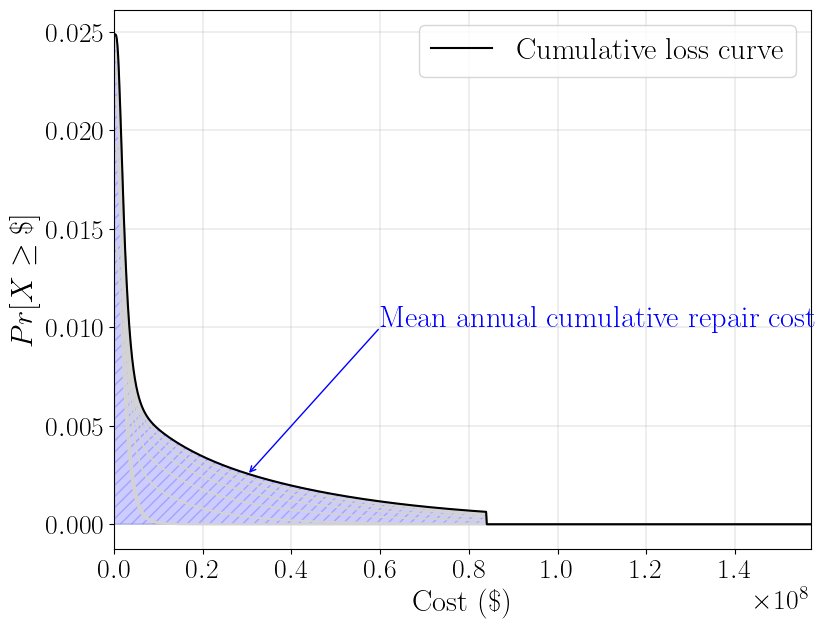

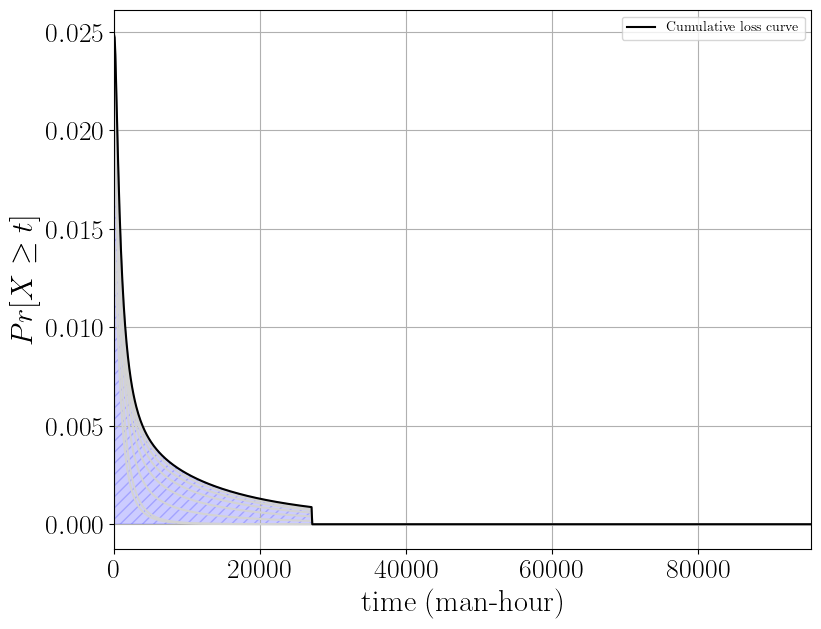

249137.64017936337 89.09510782668099


In [15]:
row_no = 0
row = df.iloc[row_no]
mcac, mcat = calculate_lifetime_loss(row,
                                    impact_clfs=impact_classification_mdls, 
                                    cost_regs=cost_regression_mdls, 
                                    time_regs=time_regression_mdls,
                                    beta_regs=beta_regression_mdls,
                                    plot_me=True)

print(mcac, mcat)

Execute MCAC calculations

In [16]:

#%% 

t0 = time.time()
df[['mean_cumulative_annual_cost', 
    'mean_cumulative_annual_time']] = df.apply(
        lambda row: calculate_lifetime_loss(row,
                                    impact_clfs=impact_classification_mdls, 
                                    cost_regs=cost_regression_mdls, 
                                    time_regs=time_regression_mdls,
                                    beta_regs=beta_regression_mdls),
        axis='columns', result_type='expand')

tp = time.time() - t0
print("Calculated lifetime losses for 1000 points in  %.3f s" % tp)

#%%
df['annual_cost_ratio'] = df['mean_cumulative_annual_cost']/df['total_cmp_cost']
df['annual_time_ratio'] = df['mean_cumulative_annual_time']/df['total_cmp_time']


Calculated lifetime losses for 1000 points in  29.670 s


Include MCAC into df

In [17]:


#%% re subsets

df_tfp = df[df['isolator_system'] == 'TFP']
df_lrb = df[df['isolator_system'] == 'LRB']

df_cbf = df[df['superstructure_system'] == 'CBF'].reset_index()
df_cbf['dummy_index'] = df_cbf['replacement_freq'] + df_cbf['index']*1e-9
df_mf = df[df['superstructure_system'] == 'MF'].reset_index()
df_mf['dummy_index'] = df_mf['replacement_freq'] + df_mf['index']*1e-9

df_mf_o = df_mf[df_mf['impacted'] == 0]
df_cbf_o = df_cbf[df_cbf['impacted'] == 0]

df_mf_tfp = df_tfp[df_tfp['superstructure_system'] == 'MF']
df_mf_lrb = df_lrb[df_lrb['superstructure_system'] == 'MF']

df_cbf_tfp = df_tfp[df_tfp['superstructure_system'] == 'CBF']
df_cbf_lrb = df_lrb[df_lrb['superstructure_system'] == 'CBF']


df_mf_tfp_i = df_mf_tfp[df_mf_tfp['impacted'] == 1]
df_mf_tfp_o = df_mf_tfp[df_mf_tfp['impacted'] == 0]
df_mf_lrb_i = df_mf_lrb[df_mf_lrb['impacted'] == 1]
df_mf_lrb_o = df_mf_lrb[df_mf_lrb['impacted'] == 0]

df_cbf_tfp_i = df_cbf_tfp[df_cbf_tfp['impacted'] == 1]
df_cbf_tfp_o = df_cbf_tfp[df_cbf_tfp['impacted'] == 0]
df_cbf_lrb_i = df_cbf_lrb[df_cbf_lrb['impacted'] == 1]
df_cbf_lrb_o = df_cbf_lrb[df_cbf_lrb['impacted'] == 0]

## Build MCAC predictor (GP-MCAC)

In [18]:
mdl_mcac_cbf_lrb = GP(df_cbf_lrb)
mdl_mcac_cbf_lrb.set_covariates(covariate_list)
mdl_mcac_cbf_lrb.set_outcome('annual_cost_ratio')
mdl_mcac_cbf_lrb.test_train_split(0.2)

mdl_mcac_cbf_tfp = GP(df_cbf_tfp)
mdl_mcac_cbf_tfp.set_covariates(covariate_list)
mdl_mcac_cbf_tfp.set_outcome('annual_cost_ratio')
mdl_mcac_cbf_tfp.test_train_split(0.2)

mdl_mcac_mf_lrb = GP(df_mf_lrb)
mdl_mcac_mf_lrb.set_covariates(covariate_list)
mdl_mcac_mf_lrb.set_outcome('annual_cost_ratio')
mdl_mcac_mf_lrb.test_train_split(0.2)

mdl_mcac_mf_tfp = GP(df_mf_tfp)
mdl_mcac_mf_tfp.set_covariates(covariate_list)
mdl_mcac_mf_tfp.set_outcome('annual_cost_ratio')
mdl_mcac_mf_tfp.test_train_split(0.2)



mdl_mcat_cbf_lrb = GP(df_cbf_lrb)
mdl_mcat_cbf_lrb.set_covariates(covariate_list)
mdl_mcat_cbf_lrb.set_outcome('annual_time_ratio')
mdl_mcat_cbf_lrb.test_train_split(0.2)

mdl_mcat_cbf_tfp = GP(df_cbf_tfp)
mdl_mcat_cbf_tfp.set_covariates(covariate_list)
mdl_mcat_cbf_tfp.set_outcome('annual_time_ratio')
mdl_mcat_cbf_tfp.test_train_split(0.2)

mdl_mcat_mf_lrb = GP(df_mf_lrb)
mdl_mcat_mf_lrb.set_covariates(covariate_list)
mdl_mcat_mf_lrb.set_outcome('annual_time_ratio')
mdl_mcat_mf_lrb.test_train_split(0.2)

mdl_mcat_mf_tfp = GP(df_mf_tfp)
mdl_mcat_mf_tfp.set_covariates(covariate_list)
mdl_mcat_mf_tfp.set_outcome('annual_time_ratio')
mdl_mcat_mf_tfp.test_train_split(0.2)

print('======= MCAC/MCAT regression per system ========')
import time
t0 = time.time()

mdl_mcac_cbf_lrb.fit_gpr(kernel_name='rbf_iso', noise_bound=(1e-13, 1e2))
mdl_mcac_cbf_tfp.fit_gpr(kernel_name='rbf_iso', noise_bound=(1e-13, 1e2))
mdl_mcac_mf_lrb.fit_gpr(kernel_name='rbf_iso', noise_bound=(1e-13, 1e2))
mdl_mcac_mf_tfp.fit_gpr(kernel_name='rbf_iso', noise_bound=(1e-13, 1e2))

mdl_mcat_cbf_lrb.fit_gpr(kernel_name='rbf_iso', noise_bound=(1e-13, 1e2))
mdl_mcat_cbf_tfp.fit_gpr(kernel_name='rbf_iso', noise_bound=(1e-13, 1e2))
mdl_mcat_mf_lrb.fit_gpr(kernel_name='rbf_iso', noise_bound=(1e-13, 1e2))
mdl_mcat_mf_tfp.fit_gpr(kernel_name='rbf_iso', noise_bound=(1e-13, 1e2))

tp = time.time() - t0

print("GPR MCAC/MCAT training for cost done for 4 models in %.3f s" % tp)

mcac_regression_mdls = {'mdl_mcac_cbf_lrb': mdl_mcac_cbf_lrb,
                        'mdl_mcac_cbf_tfp': mdl_mcac_cbf_tfp,
                        'mdl_mcac_mf_lrb': mdl_mcac_mf_lrb,
                        'mdl_mcac_mf_tfp': mdl_mcac_mf_tfp}

mcat_regression_mdls = {'mdl_mcat_cbf_lrb': mdl_mcat_cbf_lrb,
                        'mdl_mcat_cbf_tfp': mdl_mcat_cbf_tfp,
                        'mdl_mcat_mf_lrb': mdl_mcat_mf_lrb,
                        'mdl_mcat_mf_tfp': mdl_mcat_mf_tfp}

======= MCAC/MCAT regression per system ========


c:\Users\hgp\.conda\envs\ops-ts\lib\site-packages\sklearn\gaussian_process\kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\hgp\.conda\envs\ops-ts\lib\site-packages\sklearn\gaussian_process\kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\hgp\.conda\envs\ops-ts\lib\site-packages\sklearn\gaussian_process\kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\hgp\.conda\envs\ops-ts\lib\site-packages

GPR MCAC/MCAT training for cost done for 4 models in 9.432 s


c:\Users\hgp\.conda\envs\ops-ts\lib\site-packages\sklearn\gaussian_process\kernels.py:424: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Plot MCAC predictor

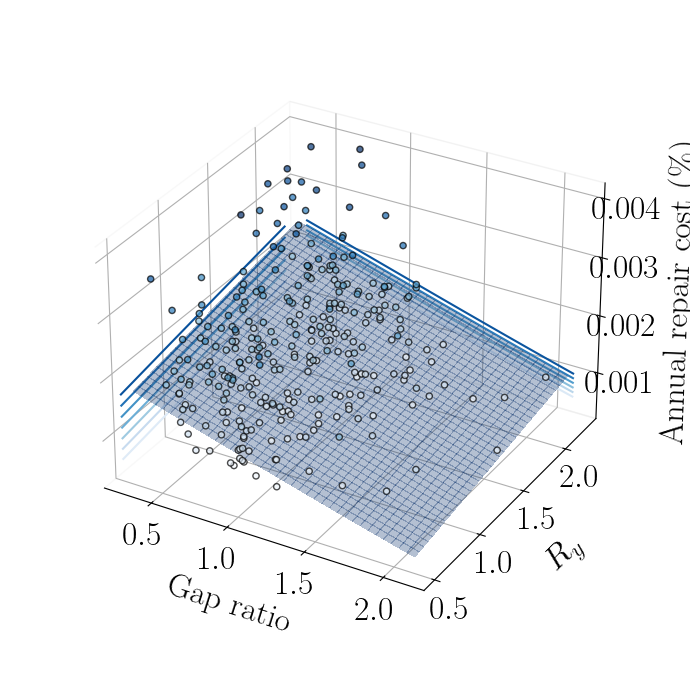

In [19]:
from inverse import make_2D_plotting_space


annual_cost_var = 'annual_cost_ratio'
mdl_mcac = mcac_regression_mdls['mdl_mcac_cbf_lrb']
impact_mdl = mdl_impact_cbf_lrb
df_sc = df_cbf_lrb.copy()

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
title_font=28
axis_font = 24
subt_font = 20
label_size = 24
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

fig = plt.figure(figsize=(9, 7))



xvar = 'gap_ratio'
yvar = 'RI'

res = 75
X_plot = make_2D_plotting_space(impact_mdl.X, res, x_var=xvar, y_var=yvar, 
                            all_vars=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'],
                            third_var_set = 5.0, fourth_var_set = 0.15)

# xx, yy = np.meshgrid(np.linspace(0.5, 12.0, res),
#                      np.linspace(0.1, 2.5, res))
# X_plot = pd.DataFrame({xvar:xx.ravel(),
#                     yvar:yy.ravel(),
#                     'T_ratio':np.repeat(5.0, res*res),
#                     'zeta_e':np.repeat(0.2, res*res)})
Z = mdl_mcac.gpr.predict(X_plot)


xx = X_plot[xvar]
yy = X_plot[yvar]
x_pl = np.unique(xx)
y_pl = np.unique(yy)
xx_pl, yy_pl = np.meshgrid(x_pl, y_pl)

Z_surf = np.array(Z).reshape(xx_pl.shape)

ax=fig.add_subplot(1, 1, 1, projection='3d')
surf = ax.plot_surface(xx_pl, yy_pl, Z_surf, cmap='Blues',
                        linewidth=0, antialiased=False, alpha=0.3,
                        vmin=-0.5)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.scatter(df_sc[xvar], df_sc[yvar], df_sc[annual_cost_var], c=df_sc[annual_cost_var],
            edgecolors='k', alpha = 0.7, cmap='Blues', zorder=20)

xlim = ax.get_xlim()
ylim = ax.get_ylim()
zlim = ax.get_zlim()
cset = ax.contour(xx_pl, yy_pl, Z_surf, zdir='x', offset=xlim[0], cmap='Blues_r')
cset = ax.contour(xx_pl, yy_pl, Z_surf, zdir='y', offset=ylim[1], cmap='Blues')
# ax.set_zlim([-0.1, 1.1])

ax.set_xlabel('Gap ratio', fontsize=axis_font, labelpad=20)
ax.set_ylabel('$R_y$', fontsize=axis_font, labelpad=20)
ax.set_zlabel('Annual repair cost (\%)', fontsize=axis_font, labelpad=20)
# ax.set_title('MF-LRB: $T_M/T_{fb} = 3.0$, $\zeta_M = 0.15$', fontsize=subt_font)
ax.set_box_aspect(None, zoom=0.85)
fig.tight_layout()

In [20]:
#%% GP models for MCACs (done without impact classif)
'''

mdl_mcac_cbf_lrb = GP(df_cbf_lrb)
mdl_mcac_cbf_lrb.set_covariates(covariate_list)
mdl_mcac_cbf_lrb.set_outcome('annual_cost_ratio')
mdl_mcac_cbf_lrb.test_train_split(0.2)

mdl_mcac_cbf_tfp = GP(df_cbf_tfp)
mdl_mcac_cbf_tfp.set_covariates(covariate_list)
mdl_mcac_cbf_tfp.set_outcome('annual_cost_ratio')
mdl_mcac_cbf_tfp.test_train_split(0.2)

mdl_mcac_mf_lrb = GP(df_mf_lrb)
mdl_mcac_mf_lrb.set_covariates(covariate_list)
mdl_mcac_mf_lrb.set_outcome('annual_cost_ratio')
mdl_mcac_mf_lrb.test_train_split(0.2)

mdl_mcac_mf_tfp = GP(df_mf_tfp)
mdl_mcac_mf_tfp.set_covariates(covariate_list)
mdl_mcac_mf_tfp.set_outcome('annual_cost_ratio')
mdl_mcac_mf_tfp.test_train_split(0.2)



mdl_mcat_cbf_lrb = GP(df_cbf_lrb)
mdl_mcat_cbf_lrb.set_covariates(covariate_list)
mdl_mcat_cbf_lrb.set_outcome('annual_time_ratio')
mdl_mcat_cbf_lrb.test_train_split(0.2)

mdl_mcat_cbf_tfp = GP(df_cbf_tfp)
mdl_mcat_cbf_tfp.set_covariates(covariate_list)
mdl_mcat_cbf_tfp.set_outcome('annual_time_ratio')
mdl_mcat_cbf_tfp.test_train_split(0.2)

mdl_mcat_mf_lrb = GP(df_mf_lrb)
mdl_mcat_mf_lrb.set_covariates(covariate_list)
mdl_mcat_mf_lrb.set_outcome('annual_time_ratio')
mdl_mcat_mf_lrb.test_train_split(0.2)

mdl_mcat_mf_tfp = GP(df_mf_tfp)
mdl_mcat_mf_tfp.set_covariates(covariate_list)
mdl_mcat_mf_tfp.set_outcome('annual_time_ratio')
mdl_mcat_mf_tfp.test_train_split(0.2)

print('======= MCAC/MCAT regression per system ========')
import time
t0 = time.time()

mdl_mcac_cbf_lrb.fit_gpr(kernel_name='rbf_iso', noise_bound=(1e-13, 1e2))
mdl_mcac_cbf_tfp.fit_gpr(kernel_name='rbf_iso', noise_bound=(1e-13, 1e2))
mdl_mcac_mf_lrb.fit_gpr(kernel_name='rbf_iso', noise_bound=(1e-13, 1e2))
mdl_mcac_mf_tfp.fit_gpr(kernel_name='rbf_iso', noise_bound=(1e-13, 1e2))

mdl_mcat_cbf_lrb.fit_gpr(kernel_name='rbf_iso', noise_bound=(1e-13, 1e2))
mdl_mcat_cbf_tfp.fit_gpr(kernel_name='rbf_iso', noise_bound=(1e-13, 1e2))
mdl_mcat_mf_lrb.fit_gpr(kernel_name='rbf_iso', noise_bound=(1e-13, 1e2))
mdl_mcat_mf_tfp.fit_gpr(kernel_name='rbf_iso', noise_bound=(1e-13, 1e2))

tp = time.time() - t0

print("GPR MCAC/MCAT training for cost done for 4 models in %.3f s" % tp)

mcac_regression_mdls = {'mdl_mcac_cbf_lrb': mdl_mcac_cbf_lrb,
                        'mdl_mcac_cbf_tfp': mdl_mcac_cbf_tfp,
                        'mdl_mcac_mf_lrb': mdl_mcac_mf_lrb,
                        'mdl_mcac_mf_tfp': mdl_mcac_mf_tfp}

mcat_regression_mdls = {'mdl_mcat_cbf_lrb': mdl_mcat_cbf_lrb,
                        'mdl_mcat_cbf_tfp': mdl_mcat_cbf_tfp,
                        'mdl_mcat_mf_lrb': mdl_mcat_mf_lrb,
                        'mdl_mcat_mf_tfp': mdl_mcat_mf_tfp}
                        
'''

'\n\nmdl_mcac_cbf_lrb = GP(df_cbf_lrb)\nmdl_mcac_cbf_lrb.set_covariates(covariate_list)\nmdl_mcac_cbf_lrb.set_outcome(\'annual_cost_ratio\')\nmdl_mcac_cbf_lrb.test_train_split(0.2)\n\nmdl_mcac_cbf_tfp = GP(df_cbf_tfp)\nmdl_mcac_cbf_tfp.set_covariates(covariate_list)\nmdl_mcac_cbf_tfp.set_outcome(\'annual_cost_ratio\')\nmdl_mcac_cbf_tfp.test_train_split(0.2)\n\nmdl_mcac_mf_lrb = GP(df_mf_lrb)\nmdl_mcac_mf_lrb.set_covariates(covariate_list)\nmdl_mcac_mf_lrb.set_outcome(\'annual_cost_ratio\')\nmdl_mcac_mf_lrb.test_train_split(0.2)\n\nmdl_mcac_mf_tfp = GP(df_mf_tfp)\nmdl_mcac_mf_tfp.set_covariates(covariate_list)\nmdl_mcac_mf_tfp.set_outcome(\'annual_cost_ratio\')\nmdl_mcac_mf_tfp.test_train_split(0.2)\n\n\n\nmdl_mcat_cbf_lrb = GP(df_cbf_lrb)\nmdl_mcat_cbf_lrb.set_covariates(covariate_list)\nmdl_mcat_cbf_lrb.set_outcome(\'annual_time_ratio\')\nmdl_mcat_cbf_lrb.test_train_split(0.2)\n\nmdl_mcat_cbf_tfp = GP(df_cbf_tfp)\nmdl_mcat_cbf_tfp.set_covariates(covariate_list)\nmdl_mcat_cbf_tfp.set_o

## Inverse design

### Cost prediction

In [21]:
# linear regress cost as f(base shear)
from sklearn.linear_model import LinearRegression
reg_mf = LinearRegression(fit_intercept=False)
reg_mf.fit(X=df_mf[['Vs']], y=df_mf[['steel_cost']])

reg_cbf = LinearRegression(fit_intercept=False)
reg_cbf.fit(X=df_cbf[['Vs']], y=df_cbf[['steel_cost']])

reg_dict = {
    'mf':reg_mf,
    'cbf':reg_cbf
    }

### Tfbe predictor

In [22]:
# linear regress cost as f(base shear)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    df_mf[['h_bldg', 'RI']].values, df_mf[['T_fb']].values, test_size=0.2, random_state=985)
reg_mf_Tfbe = LinearRegression(fit_intercept=False)
reg_mf_Tfbe.fit(X=X_train, y=y_train)
y_pred = reg_mf_Tfbe.predict(X_test)
print(f"Mean squared error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred):.2f}")

X_train, X_test, y_train, y_test = train_test_split(
    df_cbf[['h_bldg', 'RI']].values, df_cbf[['T_fb']].values, test_size=0.2, random_state=985)
reg_cbf_Tfbe = LinearRegression(fit_intercept=False)
reg_cbf_Tfbe.fit(X=X_train, y=y_train)
y_pred = reg_cbf_Tfbe.predict(X_test)
print(f"Mean squared error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"Coefficient of determination: {r2_score(y_test, y_pred):.2f}")

reg_dict_Tfbe = {
    'mf':reg_mf_Tfbe,
    'cbf':reg_cbf_Tfbe
    }

Mean squared error: 0.04
Coefficient of determination: 0.80
Mean squared error: 0.01
Coefficient of determination: 0.87


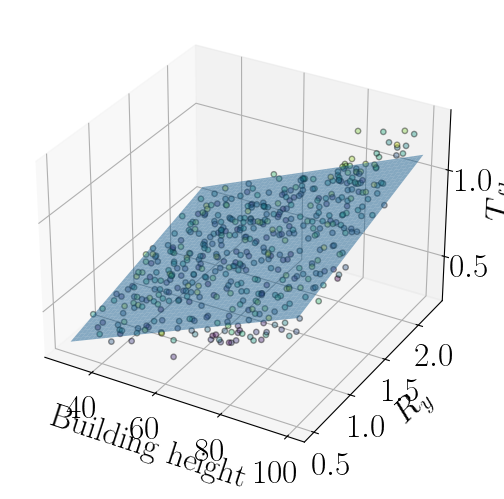

In [23]:
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1, 1, 1, projection='3d')
# df_plot = df_doe[df_doe['impacted'] == 1]
df_plot = df_cbf.copy()

x_min, x_max = 30.0, 100.0
y_min, y_max = 0.5, 2.25
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))

# 4. Predict the class for each grid point
Z = reg_cbf_Tfbe.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

ax.scatter(df_plot['h_bldg'], df_plot['RI'], df_plot['T_fb'], c=df_plot['T_m'], alpha=0.4, edgecolors='black', s=15)
ax.plot_surface(xx, yy, Z, alpha=0.5)
ax.set_ylabel('$R_y$', fontsize=axis_font)
ax.set_zlabel('$T_{fb}$', fontsize=axis_font)
ax.set_xlabel('Building height', fontsize=axis_font)
# ax.set_xlim([0, 0.1])
# ax.set_ylim([0, 0.2])
plt.show()

### Grid search inverse design

In [24]:
from inverse import calc_upfront_cost, make_design_space

def grid_search_inverse_design(res, system_name, targets_dict, config_dict, 
                               impact_clfs, mcac_regs, mcat_regs,
                               cost_var='annual_cost_ratio', time_var='annual_time_ratio'):
    import time
    
    # isolator_system = system_name.split('_')[1]
    # system_X = impact_clfs['mdl_impact_'+system_name].X
    structural_system = system_name.split('_')[0]
    
    if structural_system == 'mf':
        bound_dict = {
            'gap_ratio': (0.6, 2.0),
            'RI': (0.5, 2.25),
            'T_ratio': (2.0, 5.8),
            'zeta_e': (0.1, 0.25),
            'k_ratio': (5.0, 12.0)}
    else:
       bound_dict = {
           'gap_ratio': (0.6, 2.0),
           'RI': (0.5, 2.25),
           'T_ratio': (2.0, 11.0),
           'zeta_e': (0.1, 0.25),
           'k_ratio': (5.0, 12.0)} 
    
    X_space = make_design_space(res, bound_dict=bound_dict)
    
    # identify impact models (which has constructable kde)
    mdl_impact_name = 'mdl_impact_' + system_name
    mdl_impact = impact_clfs[mdl_impact_name]
    
    # identify cost models
    
    mdl_mcac_name = 'mdl_mcac_' + system_name
    mdl_mcac = mcac_regs[mdl_mcac_name]
    
    # identify time models
    mdl_mcat_name = 'mdl_mcat_' + system_name
    mdl_mcat = mcat_regs[mdl_mcat_name]
    
    # first, scan whole range for constructable bounds
    # constructable
    space_constr = mdl_impact.kde.score_samples(X_space)
    constr_thresh = targets_dict['constructability']
    ok_constr = X_space.loc[space_constr >= constr_thresh]
    constr_bounds = ok_constr.agg(['min', 'max'])
    variable_names = list(constr_bounds.columns)
    temp_dict = constr_bounds.to_dict()
    ranges = [tuple(temp_dict[key].values()) for key in variable_names]
    bounds = {k:v for (k,v) in zip(variable_names, ranges)}
    
    
    # then recreate a finer design space within constructable range
    X_space = make_design_space(res, bound_dict=bounds)
    
    t0 = time.time()
    space_mcac = mdl_mcac.gpr.predict(X_space)
    tp = time.time() - t0
    print("GPC-GPR MCAC prediction for %d inputs in %.3f s" % (X_space.shape[0],
                                                               tp))
    
    t0 = time.time()
    space_mcat = mdl_mcat.gpr.predict(X_space)
    tp = time.time() - t0
    print("GPC-GPR MCAT prediction for %d inputs in %.3f s" % (X_space.shape[0],
                                                                   tp))
    
    space_constr = mdl_impact.kde.score_samples(X_space)
    tp = time.time() - t0
    print("KDE constructability prediction for %d inputs in %.3f s" % (X_space.shape[0],
                                                                   tp))
    
    # filter cost threshold
    mcac_thresh = targets_dict[cost_var]
    ok_cost = X_space.loc[space_mcac<=mcac_thresh]

    # downtime threshold
    mcat_thresh = targets_dict[time_var]
    ok_time = X_space.loc[space_mcat<=mcat_thresh]

    
    # constructable
    constr_thresh = targets_dict['constructability']
    ok_constr = X_space.loc[space_constr >= constr_thresh]

    X_design = X_space[np.logical_and.reduce((
            X_space.index.isin(ok_cost.index), 
            X_space.index.isin(ok_time.index),
            X_space.index.isin(ok_constr.index)))]
    
    
    space_ok_mcac = space_mcac[X_space.index.isin(X_design.index)]
    space_ok_mcat = space_mcat[X_space.index.isin(X_design.index)]


    if X_design.shape[0] < 1:
        print('No suitable design found for system', system_name)
        return None, None, None
    
    # NPV analysis
    # compare cost of designs against baseline of that system
    
    
    if structural_system.upper() == 'MF':
        X_baseline =  pd.DataFrame(np.array([[1.0, 2.0, 2.6, 0.2]]),
                                   columns=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'])
        upfront_costs = calc_upfront_cost(
            X_design, config_dict=config_dict, steel_cost_dict=reg_dict)
        baseline_cost = calc_upfront_cost(
            X_baseline, config_dict=config_dict, steel_cost_dict=reg_dict)
        
        mcac_baseline = mdl_mcac.gpr.predict(X_baseline)[0]
        mcat_baseline = mdl_mcat.gpr.predict(X_baseline)[0]
    else:
        
        X_baseline =  pd.DataFrame(np.array([[1.0, 2.0, 5.2, 0.2]]),
                                   columns=['gap_ratio', 'RI', 'T_ratio', 'zeta_e'])
        upfront_costs = calc_upfront_cost(
            X_design, config_dict=config_dict, steel_cost_dict=reg_dict,
            land_cost_per_sqft=1978/(3.28**2))
        baseline_cost = calc_upfront_cost(
            X_baseline, config_dict=config_dict, steel_cost_dict=reg_dict,
            land_cost_per_sqft=1978/(3.28**2))
        
        mcac_baseline = mdl_mcac.gpr.predict(X_baseline)[0]
        mcat_baseline = mdl_mcat.gpr.predict(X_baseline)[0]
    
    upgrade_cost = (upfront_costs['total_'+structural_system] - 
                    baseline_cost['total_'+structural_system].item())
    
    avoided_cost = (mcac_baseline - space_ok_mcac)*config_dict['comparable_cost_'+structural_system]
    avoided_time = (mcat_baseline - space_ok_mcat)*config_dict['comparable_time_'+structural_system]
    
    # profit loss and repair cost per worker-day
    # assume 40% of replacement cost is labor, $680/worker-day for SF Bay Area
    bldg_area = (config_dict['num_bays']*config_dict['L_bay'])**2 * (config_dict['num_stories'] + 1)

    # assume $600/sf replacement
    n_worker_series = bldg_area/1000
    n_worker_parallel = n_worker_series/2
    
    # labor rate per worker-day
    avoided_worker_cost = 680.0*avoided_time
    
    # lost profits
    # worker-day (/workers) (*$ per day)
    # based on $25/sq-ft/yr of business rent in Oakland for 3 story
    avoided_business_cost = avoided_time/n_worker_parallel*4440*1.35 * config_dict['num_stories']/3
    
    avoided_time_cost = avoided_worker_cost + avoided_business_cost
    avoided_consequence = avoided_cost + avoided_time_cost
    
    i_rate = config_dict['interest_rate']
    t_yrs = config_dict['timeframe']
    
    # upgrade is worth it if NPV of avoided consequence > upgrade cost over baseline
    NPV = avoided_consequence*((1 - 1/(1 + i_rate)**t_yrs) / i_rate)
    upgrade_value = NPV - upgrade_cost
    upgrade_decision = upgrade_value > 0
    # upgrade_decision = np.repeat(True, X_design.shape[0])
    X_worth = X_design[upgrade_decision]
    worth_costs = upfront_costs['total_'+structural_system][upgrade_decision]
    
    # import matplotlib.pyplot as plt
    # plt.close('all')
    # fig = plt.figure(figsize=(8, 7))
    # ax1=fig.add_subplot(1, 1, 1)
    # ax1.plot(sa_bins, cost_bins.ravel(), '-o')
    # ax1.set_xlabel(r'$Sa(T_M)$', fontsize=axis_font)
    # ax1.set_ylabel(r'GP predicted median repair cost (\$)', fontsize=axis_font)
    # ax1.grid()
    # plt.show()
    # # ax1.set_xlim([0, row['replacement_cost']])
    
    
    design_idx = upgrade_value.idxmax()
    inv_upfront_cost = worth_costs[upgrade_value.idxmax()]
    
    # cheapest_idx = worth_costs.idxmin()
    # inv_upfront_cost = worth_costs.min()
    
    # least upfront cost of the viable designs
    inv_design = X_worth.loc[design_idx]
    inv_mcat = space_mcat[design_idx]
    inv_mcac = space_mcac[design_idx]
    inv_upgrade_cost = upgrade_cost[design_idx]
    inv_avoided_cost = (mcac_baseline - inv_mcac)*config_dict['comparable_cost_'+structural_system]
    inv_avoided_time = (mcat_baseline - inv_mcat)*config_dict['comparable_time_'+structural_system]
    inv_avoided_consequence = inv_avoided_cost + inv_avoided_time * (
        680 + 4440*1.35/n_worker_parallel * config_dict['num_stories']/3)
    inv_NPV = inv_avoided_consequence*((1 - 1/(1 + i_rate)**t_yrs) / i_rate)
    inv_comparable_mcac = inv_mcac*config_dict['comparable_cost_'+structural_system]
    inv_comparable_mcat = inv_mcat*config_dict['comparable_time_'+structural_system]
    inv_performance = {
        'mcat': inv_mcat,
        'mcac': inv_mcac,
        'upfront_cost': inv_upfront_cost,
        'upgrade_cost': inv_upgrade_cost,
        'avoided_cost': inv_avoided_cost,
        'avoided_time': inv_avoided_time,
        'NPV': inv_NPV}
    
    # TODO: if NPV is unifying loss function, use optimizer

    # read out predictions
    print('==================================')
    print('            Predictions           ')
    print('==================================')
    print('======= Targets =======')
    print('System:', system_name)
    print('MCAC fraction:', f'{mcac_thresh*100:,.2f}%')
    print('MCAT fraction:', f'{mcat_thresh*100:,.2f}%')


    print('======= Overall inverse design =======')
    print(inv_design)
    print('Upfront cost of selected design: ',
          f'${inv_upfront_cost:,.2f}')
    print('Upgrade cost over baseline design: '
          f'${inv_upgrade_cost:,.2f}')
    print('Predicted MCAC ratio: ',
          f'{inv_mcac*100:,.3f}%')
    print('Predicted comparable MCAC: '
          f'${inv_comparable_mcac:,.3f}')
    print('Predicted MCAT ratio: ',
          f'{inv_mcat*100:,.3f}%')
    print('Predicted comparable MCAT: '
          f'{inv_comparable_mcat:,.3f} worker-days')
    print('Predicted NPV: '
          f'${inv_NPV:,.2f}')
    print('Upgrade value: '
          f'${upgrade_value[design_idx]:,.2f}')
    
    return(inv_design, inv_performance, X_worth)



Design the four systems

In [25]:
### regular
ns = 4
hs = 13.
nb = 6
Lb = 30.

similar_mfs = df_mf[(df_mf['num_stories'] == ns) & (df_mf['num_bays'] == nb)]
similar_mf_cost = similar_mfs['total_cmp_cost'].median()
similar_mf_time = similar_mfs['total_cmp_time'].median()

similar_cbfs = df_cbf[(df_cbf['num_stories'] == ns) & (df_cbf['num_bays'] == nb)]
similar_cbf_cost = similar_cbfs['total_cmp_cost'].median()
similar_cbf_time = similar_cbfs['total_cmp_time'].median()


example_bldg_area = (nb*Lb)**2 * (ns + 1)
workers_parallel = example_bldg_area/1000/2

annual_cost_target_mf = 50e3/similar_mf_cost
annual_cost_target_cbf = 50e3/similar_cbf_cost

# 5 days target annually, with only 10% of the workers
annual_dt_target_mf = 5*0.1*workers_parallel/similar_mf_time
annual_dt_target_cbf = 5*0.1*workers_parallel/similar_cbf_time
config_dict_annual = {
    'num_stories': ns,
    'h_story': hs,
    'num_bays': nb,
    'num_frames': 2,
    'S_s': 2.2815,
    'L_bay': Lb,
    'S_1': 1.017,
    'h_bldg': hs*ns,
    'L_bldg': Lb*nb,
    'comparable_cost_mf': similar_mf_cost,
    'comparable_cost_cbf': similar_cbf_cost,
    'comparable_time_mf': similar_mf_time,
    'comparable_time_cbf': similar_cbf_time,
    'interest_rate': 0.07,
    'timeframe': 40.0
    }

mcac_var = 'annual_cost_ratio'
mcat_var = 'annual_time_ratio'

mf_tfp_targets= {
    mcac_var: annual_cost_target_mf,
    mcat_var: annual_dt_target_mf,
    'constructability': -5.0}

mf_lrb_targets= {
    mcac_var: annual_cost_target_mf,
    mcat_var: annual_dt_target_mf,
    'constructability': -6.0}

cbf_tfp_targets= {
    mcac_var: annual_cost_target_cbf,
    mcat_var: annual_dt_target_cbf,
    'constructability': -5.0}

cbf_lrb_targets= {
    mcac_var: annual_cost_target_cbf,
    mcat_var: annual_dt_target_cbf,
    'constructability': -6.0}


In [26]:

mf_tfp_inv_design, mf_tfp_inv_performance, mf_tfp_space = grid_search_inverse_design(
    20, 'mf_tfp', mf_tfp_targets, config_dict_annual, 
    impact_classification_mdls, mcac_regression_mdls, 
    mcat_regression_mdls)

mf_lrb_inv_design, mf_lrb_inv_performance, mf_lrb_space = grid_search_inverse_design(
    20, 'mf_lrb', mf_lrb_targets, config_dict_annual, 
    impact_classification_mdls, mcac_regression_mdls, 
    mcat_regression_mdls)

cbf_tfp_inv_design, cbf_tfp_inv_performance, cbf_tfp_space = grid_search_inverse_design(
    20, 'cbf_tfp', cbf_tfp_targets, config_dict_annual, 
    impact_classification_mdls, mcac_regression_mdls, 
    mcat_regression_mdls)

cbf_lrb_inv_design, cbf_lrb_inv_performance, cbf_lrb_space = grid_search_inverse_design(
    20, 'cbf_lrb', cbf_lrb_targets, config_dict_annual, 
    impact_classification_mdls, mcac_regression_mdls, 
    mcat_regression_mdls)

GPC-GPR MCAC prediction for 160000 inputs in 1.205 s
GPC-GPR MCAT prediction for 160000 inputs in 1.160 s
KDE constructability prediction for 160000 inputs in 2.563 s
            Predictions           
======= Targets =======
System: mf_tfp
MCAC fraction: 0.14%
MCAT fraction: 0.48%
======= Overall inverse design =======
gap_ratio    1.034349
RI           2.162742
T_ratio      2.515789
zeta_e       0.242105
Name: 147358, dtype: float64
Upfront cost of selected design:  $9,319,450.03
Upgrade cost over baseline design: $-57,739.39
Predicted MCAC ratio:  0.036%
Predicted comparable MCAC: $13,268.937
Predicted MCAT ratio:  0.089%
Predicted comparable MCAT: 7.599 worker-days
Predicted NPV: $8,805.97
Upgrade value: $66,545.37
GPC-GPR MCAC prediction for 160000 inputs in 1.627 s
GPC-GPR MCAT prediction for 160000 inputs in 1.682 s
KDE constructability prediction for 160000 inputs in 3.475 s
            Predictions           
======= Targets =======
System: mf_lrb
MCAC fraction: 0.14%
MCAT frac

### Engineering inverse design

Engineering designs for the systems. This requires for a design to exist for the inverse procedure.

In [27]:
#%% design the systems
from loads import estimate_period

from db import prepare_ida_util
import json
### regular

print ('======== designing structures ==========')
my_design = mf_tfp_inv_design.copy()
my_design['superstructure_system'] = 'MF'
my_design['isolator_system'] = 'TFP'
my_design['k_ratio'] = 10

mf_tfp_dict = my_design.to_dict()

# estimate period to find bins
test_dict = dict(mf_tfp_dict)
test_dict.update(config_dict_annual)
# tf_est = estimate_period(test_dict)
tf_est = reg_mf_Tfbe.predict(np.c_[config_dict_annual['h_bldg'], my_design['RI']]).item()
tm_est = test_dict['T_ratio']/0.9*tf_est
print(tf_est, tm_est)
sa_collapse_est = 1.5*test_dict['S_1']/tm_est
sa_mce_est = test_dict['S_1']/tm_est
sa_mf_tfp_bins, lambda_mf_tfp_bins, sa_T, lambda_T = get_hazard_bins(
    tm_est, site_hazard_curves, sa_max=sa_collapse_est)
levels_mf_tfp = sa_mf_tfp_bins/sa_mce_est

config_mf_tfp = dict(config_dict_annual)
config_mf_tfp['ida_levels'] = list(levels_mf_tfp)
config_mf_tfp['T_fbe'] = tf_est

# for TFPs, we'll readjust T_ratio by x1/0.9, since the design -> analysis process will
# change T_m by x0.9
# since in the design script, GR is applied on the unadjusted T, we'll need to adjust
# the specified GR by x0.9
mf_tfp_dict['T_ratio'] = mf_tfp_dict['T_ratio']/0.9
mf_tfp_dict['gap_ratio'] = mf_tfp_dict['gap_ratio']*0.9

# with open('../inputs/mf_tfp_annual_loss_regress.in', 'w') as file:
#     file.write(json.dumps(mf_tfp_dict))
#     file.close()
    
# with open('../inputs/mf_tfp_annual_loss_regress.cfg', 'w') as file:
#     file.write(json.dumps(config_mf_tfp))
#     file.close()
    
ida_mf_tfp_df = prepare_ida_util(mf_tfp_dict, levels=levels_mf_tfp,
                                 db_string='../../resource/',
                                 config_dict=config_mf_tfp)

print('Length of MF-TFP IDA:', len(ida_mf_tfp_df))




###################################################

my_design = cbf_tfp_inv_design.copy()
my_design['superstructure_system'] = 'CBF'
my_design['isolator_system'] = 'TFP'
my_design['k_ratio'] = 12


cbf_tfp_dict = my_design.to_dict()

# estimate period to find bins
test_dict = dict(cbf_tfp_dict)
test_dict.update(config_dict_annual)
# tf_est = estimate_period(test_dict)
tf_est = reg_cbf_Tfbe.predict(np.c_[config_dict_annual['h_bldg'], my_design['RI']]).item()
tm_est = test_dict['T_ratio']/0.9*tf_est
print(tf_est, tm_est)
sa_collapse_est = 1.5*test_dict['S_1']/tm_est
sa_mce_est = test_dict['S_1']/tm_est
sa_cbf_tfp_bins, lambda_cbf_tfp_bins, sa_T, lambda_T = get_hazard_bins(
    tm_est, site_hazard_curves, sa_max=sa_collapse_est)
levels_cbf_tfp = sa_cbf_tfp_bins/sa_mce_est

config_cbf_tfp = dict(config_dict_annual)
config_cbf_tfp['ida_levels'] = list(levels_cbf_tfp)
config_cbf_tfp['T_fbe'] = tf_est

# for TFPs, we'll readjust T_ratio by x1/0.9, since the design -> analysis process will
# change T_m by x0.9
# since in the design script, GR is applied on the unadjusted T, we'll need to adjust
# the specified GR by x0.9
cbf_tfp_dict['T_ratio'] = cbf_tfp_dict['T_ratio']/0.9
cbf_tfp_dict['gap_ratio'] = cbf_tfp_dict['gap_ratio']*0.9
    
# with open('../inputs/cbf_tfp_annual_loss_regress.in', 'w') as file:
#     file.write(json.dumps(cbf_tfp_dict))
#     file.close()
    
# with open('../inputs/cbf_tfp_annual_loss_regress.cfg', 'w') as file:
#     file.write(json.dumps(config_cbf_tfp))
#     file.close()
    
ida_cbf_tfp_df = prepare_ida_util(cbf_tfp_dict, levels=levels_cbf_tfp,
                                  db_string='../../resource/',
                                 config_dict=config_cbf_tfp)

print('Length of CBF-TFP IDA:', len(ida_cbf_tfp_df))



###################################################

my_design = mf_lrb_inv_design.copy()
my_design['superstructure_system'] = 'MF'
my_design['isolator_system'] = 'LRB'
my_design['k_ratio'] = 10

mf_lrb_dict = my_design.to_dict()

# estimate period to find bins
test_dict = dict(mf_lrb_dict)
test_dict.update(config_dict_annual)
# tf_est = estimate_period(test_dict)
tf_est = reg_mf_Tfbe.predict(np.c_[config_dict_annual['h_bldg'], my_design['RI']]).item()
tm_est = test_dict['T_ratio']*tf_est
print(tf_est, tm_est)
sa_collapse_est = 1.5*test_dict['S_1']/tm_est
sa_mce_est = test_dict['S_1']/tm_est
sa_mf_lrb_bins, lambda_mf_lrb_bins, sa_T, lambda_T = get_hazard_bins(
    tm_est, site_hazard_curves, sa_max=sa_collapse_est)
levels_mf_lrb = sa_mf_lrb_bins/sa_mce_est

config_mf_lrb = dict(config_dict_annual)
config_mf_lrb['ida_levels'] = list(levels_mf_lrb)
config_mf_lrb['T_fbe'] = tf_est

# with open('../inputs/mf_lrb_annual_loss_regress.in', 'w') as file:
#     file.write(json.dumps(mf_lrb_dict))
#     file.close()
    
# with open('../inputs/mf_lrb_annual_loss_regress.cfg', 'w') as file:
#     file.write(json.dumps(config_mf_lrb))
#     file.close()
    
ida_mf_lrb_df = prepare_ida_util(mf_lrb_dict, levels=levels_mf_lrb,
                                 db_string='../../resource/',
                                 config_dict=config_mf_lrb)

print('Length of MF-LRB IDA:', len(ida_mf_lrb_df))



###################################################

my_design = cbf_lrb_inv_design.copy()
my_design['superstructure_system'] = 'CBF'
my_design['isolator_system'] = 'LRB'
my_design['k_ratio'] = 9

cbf_lrb_dict = my_design.to_dict()

# estimate period to find bins
test_dict = dict(cbf_lrb_dict)
test_dict.update(config_dict_annual)
# tf_est = estimate_period(test_dict)
tf_est = reg_cbf_Tfbe.predict(np.c_[config_dict_annual['h_bldg'], my_design['RI']]).item()
tm_est = test_dict['T_ratio']*tf_est
print(tf_est, tm_est)
sa_collapse_est = 1.5*test_dict['S_1']/tm_est
sa_mce_est = test_dict['S_1']/tm_est
sa_cbf_lrb_bins, lambda_cbf_lrb_bins, sa_T, lambda_T = get_hazard_bins(
    tm_est, site_hazard_curves, sa_max=sa_collapse_est)
levels_cbf_lrb = sa_cbf_lrb_bins/sa_mce_est

config_cbf_lrb = dict(config_dict_annual)
config_cbf_lrb['ida_levels'] = list(levels_cbf_lrb)
config_cbf_lrb['T_fbe'] = tf_est

# with open('../inputs/cbf_lrb_annual_loss_regress.in', 'w') as file:
#     file.write(json.dumps(cbf_lrb_dict))
#     file.close()
    
# with open('../inputs/cbf_lrb_annual_loss_regress.cfg', 'w') as file:
#     file.write(json.dumps(config_cbf_lrb))
#     file.close()

ida_cbf_lrb_df = prepare_ida_util(cbf_lrb_dict, levels=levels_cbf_lrb,
                                  db_string='../../resource/',
                                 config_dict=config_cbf_lrb)


    
print('Length of CBF-LRB IDA:', len(ida_cbf_lrb_df))

======== designing structures ==========
1.654011168262444 4.623493207189756
Designs completed for 1 TFPs in 0.00 s
Designs completed for 1 moment frames in 0.22 s
Length of MF-TFP IDA: 272
0.6011379142590565 4.316573573303721
Designs completed for 1 TFPs in 0.02 s
Designs completed for 1 braced frames in 0.06 s
Length of CBF-TFP IDA: 344
1.6952028848370349 3.979265719143776
Designs completed for 1 LRBs in 0.03 s
Designs completed for 1 LRBs in 0.00 s
Designs completed for 1 moment frames in 0.07 s
Length of MF-LRB IDA: 360
0.6850861242320132 3.0098243574292876
Designs completed for 1 LRBs in 0.01 s
Designs completed for 1 braced frames in 0.06 s
Length of CBF-LRB IDA: 384


In [28]:
ida_mf_lrb_df.head()

,num_stories,h_story,num_bays,num_frames,S_s,L_bay,S_1,h_bldg,L_bldg,comparable_cost_mf,comparable_cost_cbf,comparable_time_mf,comparable_time_cbf,interest_rate,timeframe,T_fbe,gap_ratio,RI,T_ratio,zeta_e,superstructure_system,isolator_system,k_ratio,T_m,moat_ampli,W,W_s,w_fl,P_lc,all_w_cases,all_Plc_cases,d_bearing,d_lead,t_r,t,n_layers,N_lb,S_pad,S_2,T_e,k_e,Q,zeta_loop,D_m,wx,hx,h_col,hsx,Fx,Vs,beam,column,scale_factor,sa_avg,ida_level,gm_selected
0,4,13.0,6,2,2.2815,30.0,1.017,52.0,180.0,36777833.722399,39657267.510061,8519.066579,11169.250905,0.07,40.0,1.695203,1.282548,2.25,2.347368,0.202632,MF,LRB,10,3.979266,1.282548,15390.0,12150.0,"[3.0, 3.0, 3.0, 3.0, 2.0133375]","[2700.0, 2700.0, 2700.0, 2700.0, 1812.00374999...","{'1.4D': [2.0999999999999996, 2.09999999999999...","{'1.4D': [1889.9999999999998, 1889.99999999999...",36.948657,6.838759,15.107619,0.457807,33.0,16.0,19.903958,2.412601,3.979266,0.006452,0.057282,0.202628,26.314164,"[3240.0, 3240.0, 3240.0, 2430.0]","[156.0, 312.0, 468.0, 624.0]","[156.0, 156.0, 156.0, 78.0]","[156.0, 156.0, 156.0, 156.0]","[9.656215519414781, 59.51645383908199, 172.447...",516.744574,"[W27X84, W27X84, W24X84, W21X55]","[W14X233, W14X233, W14X233, W14X233]",1.486571,0.064108,0.139841,RSN930_BIGBEAR_SB2270
1,4,13.0,6,2,2.2815,30.0,1.017,52.0,180.0,36777833.722399,39657267.510061,8519.066579,11169.250905,0.07,40.0,1.695203,1.282548,2.25,2.347368,0.202632,MF,LRB,10,3.979266,1.282548,15390.0,12150.0,"[3.0, 3.0, 3.0, 3.0, 2.0133375]","[2700.0, 2700.0, 2700.0, 2700.0, 1812.00374999...","{'1.4D': [2.0999999999999996, 2.09999999999999...","{'1.4D': [1889.9999999999998, 1889.99999999999...",36.948657,6.838759,15.107619,0.457807,33.0,16.0,19.903958,2.412601,3.979266,0.006452,0.057282,0.202628,26.314164,"[3240.0, 3240.0, 3240.0, 2430.0]","[156.0, 312.0, 468.0, 624.0]","[156.0, 156.0, 156.0, 78.0]","[156.0, 156.0, 156.0, 156.0]","[9.656215519414781, 59.51645383908199, 172.447...",516.744574,"[W27X84, W27X84, W24X84, W21X55]","[W14X233, W14X233, W14X233, W14X233]",2.383341,0.064108,0.139841,RSN522_PALMSPR_INO225
2,4,13.0,6,2,2.2815,30.0,1.017,52.0,180.0,36777833.722399,39657267.510061,8519.066579,11169.250905,0.07,40.0,1.695203,1.282548,2.25,2.347368,0.202632,MF,LRB,10,3.979266,1.282548,15390.0,12150.0,"[3.0, 3.0, 3.0, 3.0, 2.0133375]","[2700.0, 2700.0, 2700.0, 2700.0, 1812.00374999...","{'1.4D': [2.0999999999999996, 2.09999999999999...","{'1.4D': [1889.9999999999998, 1889.99999999999...",36.948657,6.838759,15.107619,0.457807,33.0,16.0,19.903958,2.412601,3.979266,0.006452,0.057282,0.202628,26.314164,"[3240.0, 3240.0, 3240.0, 2430.0]","[156.0, 312.0, 468.0, 624.0]","[156.0, 156.0, 156.0, 78.0]","[156.0, 156.0, 156.0, 156.0]","[9.656215519414781, 59.51645383908199, 172.447...",516.744574,"[W27X84, W27X84, W24X84, W21X55]","[W14X233, W14X233, W14X233, W14X233]",2.532432,0.064108,0.139841,RSN523_PALMSPR_IND000
3,4,13.0,6,2,2.2815,30.0,1.017,52.0,180.0,36777833.722399,39657267.510061,8519.066579,11169.250905,0.07,40.0,1.695203,1.282548,2.25,2.347368,0.202632,MF,LRB,10,3.979266,1.282548,15390.0,12150.0,"[3.0, 3.0, 3.0, 3.0, 2.0133375]","[2700.0, 2700.0, 2700.0, 2700.0, 1812.00374999...","{'1.4D': [2.0999999999999996, 2.09999999999999...","{'1.4D': [1889.9999999999998, 1889.99999999999...",36.948657,6.838759,15.107619,0.457807,33.0,16.0,19.903958,2.412601,3.979266,0.006452,0.057282,0.202628,26.314164,"[3240.0, 3240.0, 3240.0, 2430.0]","[156.0, 312.0, 468.0, 624.0]","[156.0, 156.0, 156.0, 78.0]","[156.0, 156.0, 156.0, 156.0]","[9.656215519414781, 59.51645383908199, 172.447...",516.744574,"[W27X84, W27X84, W24X84, W21X55]","[W14X233, W14X233, W14X233, W14X233]",2.250463,0.064108,0.139841,RSN471_MORGAN_SJL270
4,4,13.0,6,2,2.2815,30.0,1.017,52.0,180.0,36777833.722399,39657267.510061,8519.066579,11169.250905,0.07,40.0,1.695203,1.282548,2.25,2.347368,0.202632,MF,LRB,10,3.979266,1.282548,15390.0,12150.0,"[3.0, 3.0, 3.0, 3.0, 2.0133375]","[2700.0, 2700.0, 2700.0, 2700.0, 1812.00374999...","{'1.4D': [2.0999999999999

## Rechecking validators

In [29]:
from inverse import loss_percentages
from gms import get_ST
def process_results(run_case):
    
    import numpy as np
    # load in validation and max run
    val_dir = '../../data/validation/'+run_case+'/'
    
    loss_file = run_case+'_loss.pickle'
    max_loss_file = run_case+'_max_loss.pickle'
    
    val_obj = pd.read_pickle(val_dir+loss_file)
    ida_results_df = val_obj.ida_results.reset_index(drop=True)
    loss_results_df = val_obj.loss_data.reset_index(drop=True)
    
    val_max_obj = pd.read_pickle(val_dir+max_loss_file)
    max_loss_results_df = val_max_obj.max_loss.reset_index(drop=True)
    
    g = 386.4
    pi = 3.14159
    
    # calculate loss ratios
    ida_results_df = loss_percentages(
        ida_results_df, loss_results_df, max_loss_results_df)
    
    # print out the results
    ida_levels = np.array(ida_results_df['ida_level'].unique())
    # ida_levels = [1.0, 1.5, 2.0]
    n = len(ida_levels)

    val_cost  = np.zeros((n,))
    val_replacement = np.zeros((n,))
    val_cost_ratio = np.zeros((n,))
    val_downtime_ratio = np.zeros((n,))
    val_downtime = np.zeros((n,))
    impact_freq = np.zeros((n,))
    struct_cost = np.zeros((n,))
    nsc_cost = np.zeros((n,))
    gap_ratios = np.zeros((n,))
    T_ratios = np.zeros((n,))
    
    GR_adjs = np.zeros((n,))
    
    isolator_system = run_case.split('_')[1]
    
    # collect variable: currently working with means of medians
    cost_var_ida = 'cost_50%'
    time_var_ida = 'time_l_50%'
    
    cost_var = 'cmp_cost_ratio'
    time_var = 'cmp_time_ratio'
    
    g = 386.4
    pi = 3.14159
    for i, lvl in enumerate(ida_levels):
        val_ida = ida_results_df[ida_results_df['ida_level']==lvl]
        loss_ida = loss_results_df[ida_results_df['ida_level']==lvl]
        
        val_replacement[i] = val_ida['replacement_freq'].mean()
        val_cost[i] = loss_ida[cost_var_ida].mean()
        val_cost_ratio[i] = val_ida[cost_var].mean()
        val_downtime[i] = loss_ida[time_var_ida].mean()
        val_downtime_ratio[i] = val_ida[time_var].mean()
        impact_freq[i] = val_ida['impacted'].mean()
        struct_cost[i] = val_ida['B_50%'].mean()
        nsc_cost[i] = val_ida['C_50%'].mean() + val_ida['D_50%'].mean() + val_ida['E_50%'].mean() 
            
        
        zetaRef = [0.02, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50]
        BmRef   = [0.8, 1.0, 1.2, 1.5, 1.7, 1.9, 2.0]
        Bm = np.interp(val_ida['zeta_e'], zetaRef, BmRef)
        
        if isolator_system == 'tfp':
            T_shifted = np.mean(val_ida['T_m']*0.9)
        else:
            T_shifted = np.mean(val_ida['T_m'])
            
        sa_tm_adj = val_ida.apply(
            lambda x: get_ST(x, T_shifted,
                              db_dir='../../resource/ground_motions/gm_db.csv',
                              spec_dir='../../resource/ground_motions/gm_spectra.csv'), 
            axis=1)
        
        
        gap_ratios_all = (val_ida['constructed_moat']*4*pi**2)/ \
            (g*(val_ida['sa_tm']/Bm)*val_ida['T_m']**2)
        gap_ratios[i] = gap_ratios_all.mean()
        
        # breakpoint()
        GR_adj = (val_ida['constructed_moat']*4*pi**2)/ \
            (g*(sa_tm_adj/Bm)*T_shifted**2)
        GR_adjs[i] = GR_adj.mean()
            
        T_ratio_adj = T_shifted / val_ida['T_fbe'].mean()
        
        T_ratios[i] = T_shifted / val_ida['T_fb'].mean()
        
    # print(T_shifted)
    # print(GR_adjs)
    # print(T_ratio_adj)
    # print(T_ratios)
    
    
    design_list = []
    ss_sys = ida_results_df['superstructure_system'].iloc[0]
    iso_sys = ida_results_df['isolator_system'].iloc[0]
    if ss_sys == 'CBF':
        design_list.extend(['beam', 'column', 'brace'])
    else:
        design_list.extend(['beam', 'column'])
    if iso_sys == 'LRB':
        design_list.extend(['d_bearing', 'd_lead', 't_r', 'n_layers'])
    else:
        design_list.extend(['mu_1', 'mu_2', 'R_1', 'R_2'])
        
    
    sys_name = ss_sys+'-'+iso_sys
    
    # design_tested = ida_results_df[['moat_ampli', 'RI', 'T_ratio' , 'zeta_e']].iloc[0]
    # design_specifics = ida_results_df[design_list].iloc[0]
    # print('==================================')
    # print('   Validation results  (1.0 MCE)  ')
    # print('==================================')
    
    # print('System:', ss_sys+'-'+iso_sys)
    # print('Average median repair cost: ',
    #       f'${val_cost[0]:,.2f}')
    # print('Repair cost ratio: ', 
    #       f'{val_cost_ratio[0]:,.3f}')
    # print('Repair time ratio: ',
    #       f'{val_downtime_ratio[0]:,.3f}')
    # print('Estimated replacement frequency: ',
    #       f'{val_replacement[0]:.2%}')
    # print(design_tested)
    # print(design_specifics)
    
    latex_string = f"& {sys_name} & {val_cost_ratio[0]:.3f} & {val_cost_ratio[1]:.3f} & {val_cost_ratio[2]:.3f} \
        & {val_downtime_ratio[0]:.3f} & {val_downtime_ratio[1]:.3f} & {val_downtime_ratio[2]:.3f}  \\\\"
    
    print(latex_string)  
    
    
    # n_workers = (ida_results_df['bldg_area']/1000).mean()

    # print('Cost total:', ida_results_df['total_cmp_cost'].mean()/1e6)
    # print('Time total:', ida_results_df['total_cmp_time'].mean()/n_workers)
    
    # print('GR:', gap_ratios)
    # print('TR:', T_ratios)
    # print('Impact:', impact_freq)
    # print('Structural cost:', struct_cost/1e6)
    # print('Non-structural cost:', nsc_cost/1e6)
    
    
    # latex_string = f"& {sys_name} & {mce_cost_ratio:.3f} & {mce_time_ratio:.3f} & {mce_repl_ratio:.3f} \
    #     & {val_cost_ratio[0]:.2f} & {GP_time_ratio:.2f} & {GP_repl_risk:.2f} &  \${upfront_cost/1e6:.2f} M \\\\"
    
    return(ida_results_df, val_replacement, val_cost, 
           val_cost_ratio, val_downtime, val_downtime_ratio)

(mf_tfp_val_results, mf_tfp_val_repl, mf_tfp_val_cost, mf_tfp_val_cost_ratio, 
 mf_tfp_val_downtime, mf_tfp_val_downtime_ratio) = process_results('mf_tfp_annual_loss_regress')
(mf_lrb_val_results, mf_lrb_val_repl, mf_lrb_val_cost, mf_lrb_val_cost_ratio, 
 mf_lrb_val_downtime, mf_lrb_val_downtime_ratio) = process_results('mf_lrb_annual_loss_regress')
(cbf_tfp_val_results, cbf_tfp_val_repl, cbf_tfp_val_cost, cbf_tfp_val_cost_ratio, 
 cbf_tfp_val_downtime, cbf_tfp_val_downtime_ratio) = process_results('cbf_tfp_annual_loss_regress')
(cbf_lrb_val_results, cbf_lrb_val_repl, cbf_lrb_val_cost, cbf_lrb_val_cost_ratio, 
 cbf_lrb_val_downtime, cbf_lrb_val_downtime_ratio) = process_results('cbf_lrb_annual_loss_regress')


& MF-TFP & 0.009 & 0.019 & 0.026         & 0.015 & 0.029 & 0.037  \\
& MF-LRB & 0.005 & 0.011 & 0.015         & 0.008 & 0.015 & 0.019  \\
& CBF-TFP & 0.002 & 0.006 & 0.008         & 0.005 & 0.014 & 0.018  \\
& CBF-LRB & 0.000 & 0.001 & 0.002         & 0.000 & 0.002 & 0.004  \\


In [30]:
ida_cbf_lrb_df.head()


,num_stories,h_story,num_bays,num_frames,S_s,L_bay,S_1,h_bldg,L_bldg,comparable_cost_mf,comparable_cost_cbf,comparable_time_mf,comparable_time_cbf,interest_rate,timeframe,T_fbe,gap_ratio,RI,T_ratio,zeta_e,superstructure_system,isolator_system,k_ratio,T_m,moat_ampli,W,W_s,w_fl,P_lc,all_w_cases,all_Plc_cases,d_bearing,d_lead,t_r,t,n_layers,N_lb,S_pad,S_2,T_e,k_e,Q,zeta_loop,D_m,wx,hx,h_col,hsx,Fx,Vs,brace,beam,column,scale_factor,sa_avg,ida_level,gm_selected
0,4,13.0,6,2,2.2815,30.0,1.017,52.0,180.0,36777833.722399,39657267.510061,8519.066579,11169.250905,0.07,40.0,0.685086,1.631579,1.881579,4.393352,0.186842,CBF,LRB,9,3.009824,1.631579,15390.0,12150.0,"[3.0, 3.0, 3.0, 3.0, 2.0133375]","[2700.0, 2700.0, 2700.0, 2700.0, 1812.00374999...","{'1.4D': [2.0999999999999996, 2.09999999999999...","{'1.4D': [1889.9999999999998, 1889.99999999999...",35.316051,6.25844,11.425262,0.439433,26.0,24.0,19.807365,3.047287,3.009824,0.011278,0.071959,0.186839,20.513078,"[3240.0, 3240.0, 3240.0, 2430.0]","[156.0, 312.0, 468.0, 624.0]","[156.0, 156.0, 156.0, 78.0]","[156.0, 156.0, 156.0, 156.0]","[60.53366688582853, 161.78681675579514, 287.53...",834.1581,"[HSS8X8X5/16, HSS8X8X1/4, HSS8X8X1/4, HSS6X6X1/4]","[W36X160, W33X141, W33X141, W33X130]","[W12X120, W12X120, W12X120, W12X120]",1.324969,0.08142,0.139841,RSN930_BIGBEAR_SB2270
1,4,13.0,6,2,2.2815,30.0,1.017,52.0,180.0,36777833.722399,39657267.510061,8519.066579,11169.250905,0.07,40.0,0.685086,1.631579,1.881579,4.393352,0.186842,CBF,LRB,9,3.009824,1.631579,15390.0,12150.0,"[3.0, 3.0, 3.0, 3.0, 2.0133375]","[2700.0, 2700.0, 2700.0, 2700.0, 1812.00374999...","{'1.4D': [2.0999999999999996, 2.09999999999999...","{'1.4D': [1889.9999999999998, 1889.99999999999...",35.316051,6.25844,11.425262,0.439433,26.0,24.0,19.807365,3.047287,3.009824,0.011278,0.071959,0.186839,20.513078,"[3240.0, 3240.0, 3240.0, 2430.0]","[156.0, 312.0, 468.0, 624.0]","[156.0, 156.0, 156.0, 78.0]","[156.0, 156.0, 156.0, 156.0]","[60.53366688582853, 161.78681675579514, 287.53...",834.1581,"[HSS8X8X5/16, HSS8X8X1/4, HSS8X8X1/4, HSS6X6X1/4]","[W36X160, W33X141, W33X141, W33X130]","[W12X120, W12X120, W12X120, W12X120]",2.293740,0.08142,0.139841,RSN522_PALMSPR_INO225
2,4,13.0,6,2,2.2815,30.0,1.017,52.0,180.0,36777833.722399,39657267.510061,8519.066579,11169.250905,0.07,40.0,0.685086,1.631579,1.881579,4.393352,0.186842,CBF,LRB,9,3.009824,1.631579,15390.0,12150.0,"[3.0, 3.0, 3.0, 3.0, 2.0133375]","[2700.0, 2700.0, 2700.0, 2700.0, 1812.00374999...","{'1.4D': [2.0999999999999996, 2.09999999999999...","{'1.4D': [1889.9999999999998, 1889.99999999999...",35.316051,6.25844,11.425262,0.439433,26.0,24.0,19.807365,3.047287,3.009824,0.011278,0.071959,0.186839,20.513078,"[3240.0, 3240.0, 3240.0, 2430.0]","[156.0, 312.0, 468.0, 624.0]","[156.0, 156.0, 156.0, 78.0]","[156.0, 156.0, 156.0, 156.0]","[60.53366688582853, 161.78681675579514, 287.53...",834.1581,"[HSS8X8X5/16, HSS8X8X1/4, HSS8X8X1/4, HSS6X6X1/4]","[W36X160, W33X141, W33X141, W33X130]","[W12X120, W12X120, W12X120, W12X120]",2.335402,0.08142,0.139841,RSN523_PALMSPR_IND000
3,4,13.0,6,2,2.2815,30.0,1.017,52.0,180.0,36777833.722399,39657267.510061,8519.066579,11169.250905,0.07,40.0,0.685086,1.631579,1.881579,4.393352,0.186842,CBF,LRB,9,3.009824,1.631579,15390.0,12150.0,"[3.0, 3.0, 3.0, 3.0, 2.0133375]","[2700.0, 2700.0, 2700.0, 2700.0, 1812.00374999...","{'1.4D': [2.0999999999999996, 2.09999999999999...","{'1.4D': [1889.9999999999998, 1889.99999999999...",35.316051,6.25844,11.425262,0.439433,26.0,24.0,19.807365,3.047287,3.009824,0.011278,0.071959,0.186839,20.513078,"[3240.0, 3240.0, 3240.0, 2430.0]","[156.0, 312.0, 468.0, 624.0]","[156.0, 156.0, 156.0, 78.0]","[156.0, 156.0, 156.0, 156.0]","[60.53366688582853, 161.78681675579514, 287.53...",834.1581,"[HSS8X8X5/16, HSS8X8X1/4, HSS8X8X1/4, HSS6X6X1/4]","[W36X160, W33X141, W33X141, W33X130]","[W12X120, W12X120, W12X120, W12X120]",2.000377,0.08142,0.139841,RSN471_MORGAN_SJL270
4,4,13.0,6,2,2.2815,30.0,1.017,52.0,180.0,36777833.722399,39657267.510061,85

In [31]:
cbf_lrb_val_results.head()

,num_stories,h_story,num_bays,num_frames,S_s,L_bay,S_1,h_bldg,L_bldg,comparable_cost_mf,comparable_cost_cbf,comparable_time_mf,comparable_time_cbf,interest_rate,timeframe,T_fbe,gap_ratio,RI,T_ratio,zeta_e,superstructure_system,isolator_system,k_ratio,T_m,moat_ampli,W,W_s,w_fl,P_lc,all_w_cases,all_Plc_cases,d_bearing,d_lead,t_r,t,n_layers,N_lb,S_pad,S_2,T_e,k_e,Q,zeta_loop,D_m,wx,hx,h_col,hsx,Fx,Vs,brace,beam,column,scale_factor,sa_avg,ida_level,gm_selected,sa_tm,sa_1,sa_tfb,constructed_moat,T_1,T_fb,T_ratio,gap_ratio,max_isol_disp,PID,PFV,PFA,RID,impacted,run_status,bldg_area,replacement_cost,total_cmp_cost,total_cmp_cost_ub,cmp_replace_cost_ratio,median_cost_ratio,cmp_cost_ratio,replacement_time,total_cmp_time,total_cmp_time_ub,cmp_replace_time_ratio,median_time_ratio,cmp_time_ratio,replacement_freq,B_50%,C_50%,D_50%,E_50%,cost_theta,cost_beta,time_l_theta,time_l_beta,cost_lam,cost_k,time_l_k,time_l_lam,cost_weibull_ks_pvalue,cost_lognormal_ks_pvalue,time_l_weibull_ks_pvalue,time_l_lognormal_ks_pvalue,cost_weibull_aic,cost_lognormal_aic,time_l_weibull_aic,time_l_lognormal_aic
0,4,13.0,6,2,2.2815,30.0,1.017,52.0,180.0,36777833.722399,39657267.510061,8519.066579,11169.250905,0.07,40.0,0.685086,1.631579,1.881579,4.393352,0.186842,CBF,LRB,9,3.009824,1.631579,15390.0,12150.0,"[3.0, 3.0, 3.0, 3.0, 2.0133375]","[2700.0, 2700.0, 2700.0, 2700.0, 1812.00374999...","{'1.4D': [2.0999999999999996, 2.09999999999999...","{'1.4D': [1889.9999999999998, 1889.99999999999...",35.316051,6.25844,11.425262,0.439433,26.0,24.0,19.807365,3.047287,3.009824,0.011278,0.071959,0.186839,20.513078,"[3240.0, 3240.0, 3240.0, 2430.0]","[156.0, 312.0, 468.0, 624.0]","[156.0, 156.0, 156.0, 78.0]","[156.0, 156.0, 156.0, 156.0]","[60.53366688582853, 161.78681675579514, 287.53...",834.1581,"[HSS8X8X5/16, HSS8X8X1/4, HSS8X8X1/4, HSS6X6X1/4]","[W36X160, W33X141, W33X141, W33X130]","[W12X120, W12X120, W12X120, W12X120]",1.324969,0.08142,0.139841,RSN930_BIGBEAR_SB2270,0.031667,0.14164,0.221991,33.468706,1.408416,0.624322,4.820946,17.409128,1.89451,"[0.0007385256410256413, 0.0007492948717948714,...","[7.89499, 8.60204, 9.56529, 10.5286, 11.4978]","[0.09467106625258799, 0.07755124223602486, 0.0...","[0.00011401923076923093, 0.0001144871794871794...",0,0,162000.0,97200000.0,4.614251e+07,5.828394e+07,0.474717,0.000118,0.000248,59130.0,13187.08227,18018.086486,0.223018,0.000111,0.000498,0.0,0.0,10885.645245,0.0,0.0,3644.481698,10.423668,5.808035,1.372425,12042.197531,0.608348,0.963660,9.912579,2.763693e-70,5.941293e-142,9.274288e-34,2.580725e-45,20854.153283,21761.867836,6626.790340,7203.471153
1,4,13.0,6,2,2.2815,30.0,1.017,52.0,180.0,36777833.722399,39657267.510061,8519.066579,11169.250905,0.07,40.0,0.685086,1.631579,1.881579,4.393352,0.186842,CBF,LRB,9,3.009824,1.631579,15390.0,12150.0,"[3.0, 3.0, 3.0, 3.0, 2.0133375]","[2700.0, 2700.0, 2700.0, 2700.0, 1812.00374999...","{'1.4D': [2.0999999999999996, 2.09999999999999...","{'1.4D': [1889.9999999999998, 1889.99999999999...",35.316051,6.25844,11.425262,0.439433,26.0,24.0,19.807365,3.047287,3.009824,0.011278,0.071959,0.186839,20.513078,"[3240.0, 3240.0, 3240.0, 2430.0]","[156.0, 312.0, 468.0, 624.0]","[156.0, 156.0, 156.0, 78.0]","[156.0, 156.0, 156.0, 156.0]","[60.53366688582853, 161.78681675579514, 287.53...",834.1581,"[HSS8X8X5/16, HSS8X8X1/4, HSS8X8X1/4, HSS6X6X1/4]","[W36X160, W33X141, W33X141, W33X130]","[W12X120, W12X120, W12X120, W12X120]",2.29374,0.08142,0.139841,RSN522_PALMSPR_INO225,0.054812,0.16117,0.166349,33.468706,1.408416,0.624322,4.820946,10.057967,2.41307,"[0.0007053846153846163, 0.0007049358974358954,...","[8.35228, 8.79681, 9.2635, 9.7176, 10.1685]","[0.07873498964803313, 0.07632712215320911, 0.0...","[4.427884615384613e-05, 4.477051282051284e-05,...",0,0,162000.0,97200000.0,4.614251e+07,5.828394e+07,0.474717,0.000094,0.000198,59130.0,13187.08227,18018.086486,0.223018,0.000099,0.000443,0.0,0.0,9003.049183,0.0,0.0,2097.115588,12.898388,4.736443,1.457458,8594.008356,0.524707,1.053324,8.218388,1.453339e-111,

### Detailed curve checking

15152.147982386687 8.527393646843265
18298.233124295377 6.358119114095231


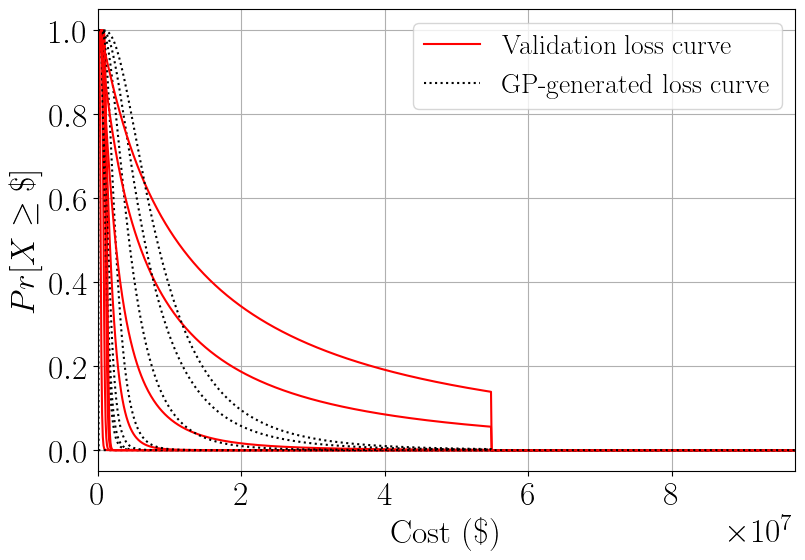

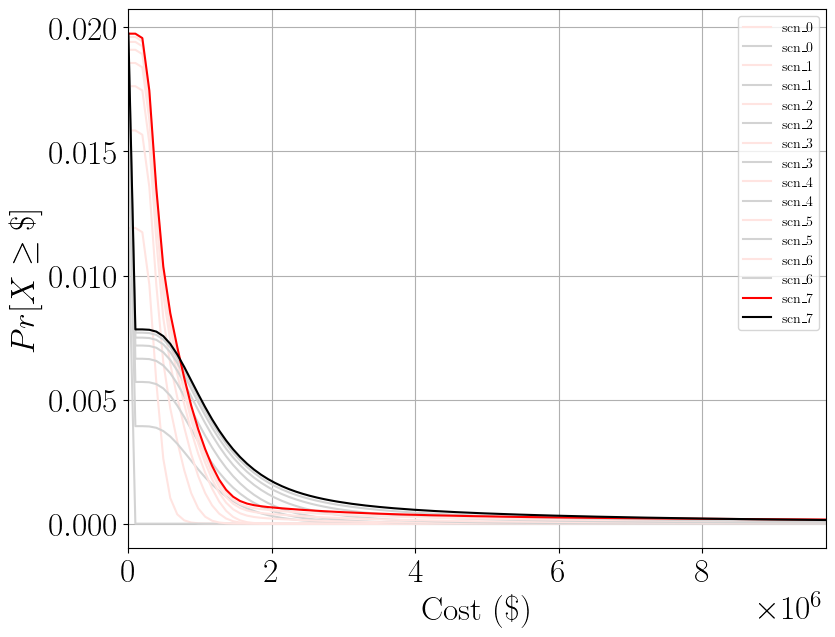

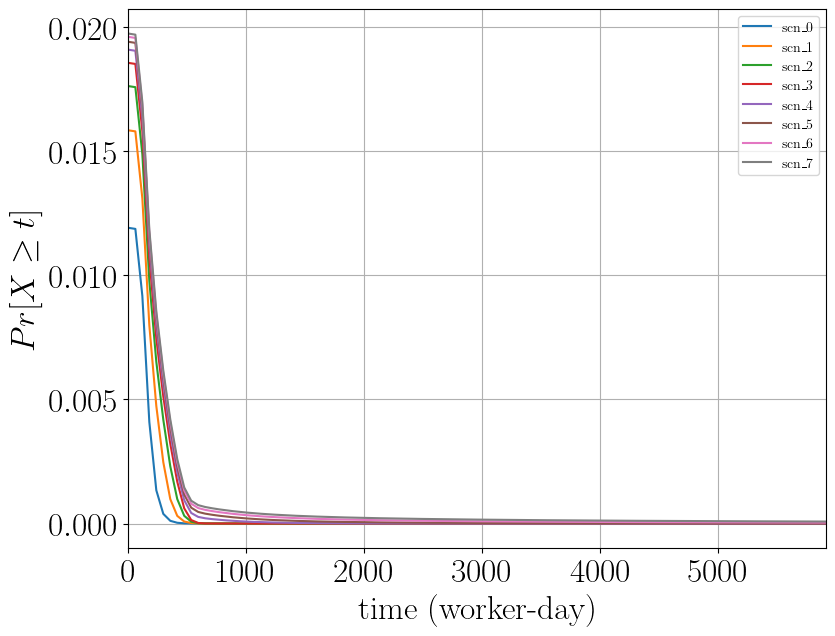

In [32]:
# make lambda function for generic lognormal distribution
import numpy as np
lognorm_f = lambda x,theta,beta: norm(np.log(theta), beta**0.5).cdf(np.log(x))

from matplotlib.lines import Line2D

def validate_lifetime_loss(val_results, hazard_curves, impact_clfs, cost_regs, time_regs, beta_regs,
                           cost_var='cmp_cost_ratio', time_var='cmp_time_ratio', plot_me=False):
    
    # pick the correct GP models
    # get system name
    supers = val_results.iloc[0]['superstructure_system'].lower()
    isols = val_results.iloc[0]['isolator_system'].lower()
    system_name = str(supers) + '_' + str(isols)
    
    # identify cost models
    mdl_impact_name = 'mdl_impact_' + system_name
    mdl_cost_hit_name = 'mdl_cost_' + system_name + '_i'
    mdl_cost_miss_name = 'mdl_cost_' + system_name + '_o'
    
    mdl_impact = impact_clfs[mdl_impact_name]
    mdl_cost_hit = cost_regs[mdl_cost_hit_name]
    mdl_cost_miss = cost_regs[mdl_cost_miss_name]
    
    # identify time models
    mdl_time_hit_name = 'mdl_time_' + system_name + '_i'
    mdl_time_miss_name = 'mdl_time_' + system_name + '_o'
    
    mdl_time_hit = time_regs[mdl_time_hit_name]
    mdl_time_miss = time_regs[mdl_time_miss_name]
    
    
    # get return rate of the three Sa_avg of the IDA
    T_m = val_results['T_m'].unique().item()
    T_list = [0.0, 0.1, 0.2, 0.3, 0.5, 0.75, 1.0, 2.0, 3.0, 4.0, 5.0]
    idx_between = bisect.bisect(T_list, T_m)
    
    # 0 is total
    below_lambda = hazard_curves[idx_between-1]['data'][0]['yvalues']
    below_sa = hazard_curves[idx_between-1]['metadata']['xvalues']
    
    above_lambda = hazard_curves[idx_between]['data'][0]['yvalues']
    above_sa = hazard_curves[idx_between]['metadata']['xvalues']
    
    x2 = T_list[idx_between]
    x1 = T_list[idx_between-1]
    # assume that both series have the same length
    sa_T = [(g + h) / 2 for g, h in zip(below_sa, above_sa)]
    lambda_T = [y1+(T_m-x1)*(y2-y1)/(x2-x1) for y1, y2 in zip(below_lambda, above_lambda)]
    
    # value to renormalize ratio into consequences
    total_cmp_cost = val_results['total_cmp_cost'].median()
    total_cmp_time = val_results['total_cmp_time'].median()
    
    # upper bound of considered replacement
    total_cmp_cost_ub = val_results['total_cmp_cost_ub'].median()
    total_cmp_time_ub = val_results['total_cmp_time_ub'].median()
    
    # value to set max of linspace array of consequences of exceedance curve
    repl_cost_max = val_results['replacement_cost'].median()
    repl_time_max = val_results['replacement_time'].median()
    cost_loss_values = np.linspace(1e-4, repl_cost_max, 1000)
    time_loss_values = np.linspace(1e-4, repl_time_max, 1000)
    
    # # grab Sa_avg of IDA
    # sa_bins = np.array([float(sa) for sa in val_results['sa_avg'].unique()])
    
    # grab Sa_Tm average of IDA level
    ida_levels = np.array([float(lvl) for lvl in val_results['ida_level'].unique()])
    sa_bins = np.zeros(len(ida_levels))
    GR_bins = np.zeros(len(ida_levels))
    Dm_bins = np.zeros(len(ida_levels))
    Ry_bins = np.zeros(len(ida_levels))
    
    zetaRef = [0.02, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50]
    BmRef   = [0.8, 1.0, 1.2, 1.5, 1.7, 1.9, 2.0]
    
    g = 386.4
    pi = 3.14159
    
    for scn_idx, ida_lvl in enumerate(ida_levels):
        ida_df = val_results[val_results['ida_level']==ida_lvl]
        sa_bins[scn_idx] = ida_df['sa_tm'].mean()
        BM = np.interp(ida_df['zeta_e'].mean(), zetaRef, BmRef)
        
        # Ry changes?
        Dm_bins[scn_idx] = g*sa_bins[scn_idx]*ida_df['T_m'].mean()**2/(4*pi**2 * BM) 
        
        k_e = ida_df['k_e'].mean()
        W = ida_df['W'].mean()
        W_s = ida_df['W_s'].mean()
        zeta_e = ida_df['zeta_e'].mean()
        Vs = ida_df['Vs'].mean()
        num_frames = ida_df['num_frames'].mean()
        
        Ry_bins[scn_idx] = (Dm_bins[scn_idx]*k_e*W*(W_s/W)**(1 - 2.5*zeta_e)/
                (Vs * num_frames))
    
        GR_bins[scn_idx] = (ida_df['constructed_moat'].mean()*4*3.19154**2)/ \
            (g*(sa_bins[scn_idx]/BM)*ida_df['T_m'].mean()**2)
            
    # interpolate in logspace
    log_lambda = np.log(lambda_T)
    log_lambda[log_lambda == -np.inf] = -100
    lambda_bins = np.exp(np.interp(np.log(sa_bins), np.log(sa_T), log_lambda))
    ##########################
    
    # set of new design variables corresponding to the bins' hazards
    if isols == 'tfp':
        Tratio_val = val_results['T_m'].mean()/val_results['T_fb'].mean()*0.9
    else:
        Tratio_val = val_results['T_m'].mean()/val_results['T_fb'].mean()
        
    zeta_val = val_results['zeta_e'].mean()
    Ry_val = val_results['RI'].mean()
    
    X_bins = pd.DataFrame({'gap_ratio':GR_bins,
                            'RI':Ry_bins,
                            'T_ratio':np.repeat(Tratio_val, len(GR_bins)),
                            'zeta_e':np.repeat(zeta_val, len(GR_bins))
                            })
    
    
    # X_bins = pd.DataFrame({'gap_ratio':GR_bins,
    #                         'RI':np.repeat(Ry_val, len(GR_bins)),
    #                         'T_ratio':np.repeat(Tratio_val, len(GR_bins)),
    #                         'zeta_e':np.repeat(zeta_val, len(GR_bins))
    #                         })
    
     # identify beta models
    mdl_cost_beta_name = 'mdl_beta_cost_' + system_name
    mdl_time_beta_name = 'mdl_beta_time_' + system_name
    
    mdl_cost_beta = beta_regs[mdl_cost_beta_name]
    mdl_time_beta = beta_regs[mdl_time_beta_name]
    
    # for the set of "new" design variables, use GP to calculate loss ratio
    # assumes GPC/GPR, predict the outcome for the design space
    cost_ratio_bins = predict_DV(X_bins, 
                                   mdl_impact.gpc, 
                                   mdl_cost_hit.gpr, 
                                   mdl_cost_miss.gpr, 
                                   outcome=cost_var)
    
    
    time_ratio_bins = predict_DV(X_bins,
                                mdl_impact.gpc,
                                mdl_time_hit.gpr,
                                mdl_time_miss.gpr,
                                outcome=time_var)
    # using kr + savgol filter smoothing to find beta from theta
    nplot = 1000
    xx_pr = np.linspace(1e-4, 1.2, nplot).reshape(-1,1)
    yy_pr = mdl_cost_beta.kr.predict(xx_pr)
    y_sm = smooth(yy_pr.ravel(), int(.05*nplot))
    cost_beta_bins = np.interp(cost_ratio_bins[cost_var+'_pred'].values, 
                                xx_pr.ravel(), y_sm)
    
    yy_pr = mdl_time_beta.kr.predict(xx_pr)
    y_sm = smooth(yy_pr.ravel(), int(.05*nplot))
    time_beta_bins = np.interp(time_ratio_bins[time_var+'_pred'].values, 
                                xx_pr.ravel(), y_sm)
    
    cost_bins_GP = cost_ratio_bins.values*total_cmp_cost
    time_bins_GP = time_ratio_bins.values*total_cmp_time
    
    cost_bins_GP[cost_bins_GP < 0.0] = 1.0
    time_bins_GP[time_bins_GP < 0.0] = 0.04167
    
    
    cost_scns_GP = np.zeros([len(cost_loss_values), len(cost_bins_GP)])
    time_scns_GP = np.zeros([len(time_loss_values), len(time_bins_GP)])
    
    
    for scn_idx in range(len(cost_bins_GP)):
        
        cost_scns_GP[:,scn_idx] = lognorm_f(cost_loss_values, cost_bins_GP[scn_idx], cost_beta_bins[scn_idx])
        time_scns_GP[:,scn_idx] = lognorm_f(time_loss_values, time_bins_GP[scn_idx], time_beta_bins[scn_idx])
        
    cost_scns_GP[cost_loss_values > total_cmp_cost_ub, :] = 1.0
    time_scns_GP[time_loss_values > total_cmp_time_ub, :] = 1.0
    
    pr_exceedance_cost_GP = 1 - cost_scns_GP
    pr_exceedance_time_GP = 1 - time_scns_GP
    
    cost_loss_rates_GP = np.multiply(pr_exceedance_cost_GP, lambda_bins)
    time_loss_rates_GP = np.multiply(pr_exceedance_time_GP, lambda_bins)
    
    # multiply scenarios' exceedance curve with corresponding return rate
    # sum across all scenarios
    agg_cost_exceedance_rate_GP = pr_exceedance_cost_GP @ lambda_bins
    agg_time_exceedance_rate_GP = pr_exceedance_time_GP @ lambda_bins
    
    # integrate to attain lifetime dollar, time
    mean_cumulative_annual_cost_GP = np.trapz(agg_cost_exceedance_rate_GP, cost_loss_values)
    mean_cumulative_annual_time_GP = np.trapz(agg_time_exceedance_rate_GP, time_loss_values)
    
    print(mean_cumulative_annual_cost_GP, mean_cumulative_annual_time_GP)
    ################################
    
    # two choice: fit lognormal OR use ECDF
    f = lambda x,theta,beta: norm(np.log(theta), beta).cdf(np.log(x))
    
    cost_scns = np.zeros([len(cost_loss_values), len(sa_bins)])
    time_scns = np.zeros([len(time_loss_values), len(sa_bins)])
    
    
    for scn_idx, ida_lvl in enumerate(ida_levels):
        ida_df = val_results[val_results['ida_level']==ida_lvl]
    
        # from individual IDA result, calculate distribution
        cost_ratio_ida = ida_df[cost_var]
        theta_cost = np.exp(np.log(cost_ratio_ida).mean())
        beta_cost = np.log(cost_ratio_ida).var()
        
        time_ratio_ida = ida_df[time_var]
        theta_time = np.exp(np.log(time_ratio_ida).mean())
        beta_time = np.log(time_ratio_ida).var()
        
        # unnormalize loss ratio back to loss
        cost_bins = cost_ratio_ida*total_cmp_cost
        time_bins = time_ratio_ida*total_cmp_time
        
        # make exceedance curve for each scenario
        # use total replacement just to have a bigger number
        cost_scns[:,scn_idx] = lognorm_f(cost_loss_values, theta_cost*total_cmp_cost, beta_cost)
        time_scns[:,scn_idx] = lognorm_f(time_loss_values, theta_time*total_cmp_time, beta_time)
        
        
    # upper bound of considered replacement
    cost_scns[cost_loss_values > total_cmp_cost_ub, :] = 1.0
    time_scns[time_loss_values > total_cmp_time_ub, :] = 1.0
    
    
    pr_exceedance_cost = 1 - cost_scns
    pr_exceedance_time = 1 - time_scns
    
    cost_loss_rates = np.multiply(pr_exceedance_cost, lambda_bins)
    time_loss_rates = np.multiply(pr_exceedance_time, lambda_bins)
    
    
    if plot_me:
        import matplotlib.pyplot as plt
        # plt.close('all')
        fig = plt.figure(figsize=(9, 6))
        ax1=fig.add_subplot(1, 1, 1)
        
        for scn_idx in range(len(sa_bins)):
            ax1.plot(cost_loss_values, pr_exceedance_cost[:,scn_idx], label='scn_'+str(scn_idx), color='red')
            ax1.plot(cost_loss_values, pr_exceedance_cost_GP[:,scn_idx], label='scn_'+str(scn_idx), color='black', linestyle=':')
        ax1.legend()
        ax1.set_xlabel(r'Cost (\$)', fontsize=axis_font)
        ax1.set_ylabel(r'$Pr[X \geq \$]$', fontsize=axis_font)
        ax1.grid()
        ax1.set_xlim([0, repl_cost_max])
        custom_lines = [Line2D([-1], [-1], color='red', 
                        linestyle='-'),
                    Line2D([-1], [-1], color='black', 
                                        linestyle=':' ),
                    ]

        ax1.legend(custom_lines, ['Validation loss curve', 'GP-generated loss curve'], 
            fontsize=subt_font)
        
        ####
        
        # fig = plt.figure(figsize=(9, 7))
        # ax1=fig.add_subplot(1, 1, 1)
        
        # for scn_idx in range(len(sa_bins)):
        #     if scn_idx != (len(sa_bins)-1):
        #         ax1.plot(cost_loss_values, cost_loss_rates[:,scn_idx], label='scn_'+str(scn_idx),
        #                 color='mistyrose')
        #         ax1.plot(cost_loss_values, cost_loss_rates_GP[:,scn_idx], label='scn_'+str(scn_idx),
        #                 color='lightgray')
        #     else:
        #         ax1.plot(cost_loss_values, cost_loss_rates[:,scn_idx], label='scn_'+str(scn_idx),
        #                 color='red')
        #         ax1.plot(cost_loss_values, cost_loss_rates_GP[:,scn_idx], label='scn_'+str(scn_idx),
        #                 color='black')
        # ax1.set_xlabel(r'Cost (\$)', fontsize=axis_font)
        # ax1.set_ylabel(r'$Pr[X \geq \$]$', fontsize=axis_font)
        # ax1.grid()
        # ax1.set_xlim([0, 0.1*repl_cost_max])
        
        ###
        
        fig = plt.figure(figsize=(9, 7))
        ax1=fig.add_subplot(1, 1, 1)
        
        for scn_idx in range(len(sa_bins)):
            if scn_idx != (len(sa_bins)-1):
                ax1.plot(cost_loss_values, cost_loss_rates[:,:scn_idx+1].sum(axis=1), label='scn_'+str(scn_idx),
                        color='mistyrose')
                ax1.plot(cost_loss_values, cost_loss_rates_GP[:,:scn_idx+1].sum(axis=1), label='scn_'+str(scn_idx),
                        color='lightgray')
            else:
                ax1.plot(cost_loss_values, cost_loss_rates[:,:scn_idx+1].sum(axis=1), label='scn_'+str(scn_idx),
                        color='red')
                ax1.plot(cost_loss_values, cost_loss_rates_GP[:,:scn_idx+1].sum(axis=1), label='scn_'+str(scn_idx),
                        color='black')
        ax1.legend()
        ax1.set_xlabel(r'Cost (\$)', fontsize=axis_font)
        ax1.set_ylabel(r'$Pr[X \geq \$]$', fontsize=axis_font)
        ax1.grid()
        ax1.set_xlim([0, 0.1*repl_cost_max])
        
        fig = plt.figure(figsize=(9, 7))
        ax1=fig.add_subplot(1, 1, 1)
        
        for scn_idx in range(len(sa_bins)):
            ax1.plot(time_loss_values, time_loss_rates[:,:scn_idx+1].sum(axis=1), label='scn_'+str(scn_idx))
        ax1.legend()
        ax1.set_xlabel(r'time (worker-day)', fontsize=axis_font)
        ax1.set_ylabel(r'$Pr[X \geq t]$', fontsize=axis_font)
        ax1.grid()
        ax1.set_xlim([0, 0.1*repl_time_max])
    
    # breakpoint()
    
    # multiply scenarios' exceedance curve with corresponding return rate
    # sum across all scenarios
    agg_cost_exceedance_rate = pr_exceedance_cost @ lambda_bins
    agg_time_exceedance_rate = pr_exceedance_time @ lambda_bins
    
    # integrate to attain lifetime dollar, time
    mean_cumulative_annual_cost = np.trapz(agg_cost_exceedance_rate, cost_loss_values)
    mean_cumulative_annual_time = np.trapz(agg_time_exceedance_rate, time_loss_values)
    
    # renormalize
    mcac_ratio = mean_cumulative_annual_cost/total_cmp_cost
    mcat_ratio = mean_cumulative_annual_time/total_cmp_time
    
    return mean_cumulative_annual_cost, mean_cumulative_annual_time, mcac_ratio, mcat_ratio


# mcac_mf_tfp, mcat_mf_tfp, mcac_ratio_mf_tfp, mcat_ratio_mf_tfp = validate_lifetime_loss(
#     mf_tfp_val_results, site_hazard_curves, 
#     impact_clfs=impact_classification_mdls, 
#     cost_regs=cost_regression_mdls, 
#     time_regs=time_regression_mdls,
#     beta_regs=beta_regression_mdls)


# mcac_mf_lrb, mcat_mf_lrb, mcac_ratio_mf_lrb, mcat_ratio_mf_lrb = validate_lifetime_loss(
#     mf_lrb_val_results, site_hazard_curves,
#     impact_clfs=impact_classification_mdls, 
#     cost_regs=cost_regression_mdls, 
#     time_regs=time_regression_mdls,
#     beta_regs=beta_regression_mdls)

# mcac_cbf_tfp, mcat_cbf_tfp, mcac_ratio_cbf_tfp, mcat_ratio_cbf_tfp = validate_lifetime_loss(
#     cbf_tfp_val_results, site_hazard_curves,
#     impact_clfs=impact_classification_mdls, 
#     cost_regs=cost_regression_mdls, 
#     time_regs=time_regression_mdls,
#     beta_regs=beta_regression_mdls)


mcac_val, mcat_val, mcac_ratio_val, mcat_ratio_val = validate_lifetime_loss(
    mf_tfp_val_results, site_hazard_curves,
    impact_clfs=impact_classification_mdls, 
    cost_regs=cost_regression_mdls, 
    time_regs=time_regression_mdls,
    beta_regs=beta_regression_mdls, plot_me=True)

print(mcac_val, mcat_val)